In [1]:
import sys
sys.path.insert(0, "../")
import scanpy as sc
from model.embedding import embed
import numpy as np

In [2]:
model_dir = "../assets/"
adata_path = "../data/NB.bone.Met_preprocessed.h5ad" # INSERT the path to your anndata object here

# 1. Load the full AnnData object
print(f"Loading full AnnData object from: {adata_path}")
adata_full = sc.read_h5ad(adata_path)
print(f"Successfully loaded. Original shape: {adata_full.shape}")

# --- Subsampling Step ---
fraction_to_keep = 0.05
# For reproducibility of the random sampling
random_seed = 42
np.random.seed(random_seed)
n_obs_original = adata_full.n_obs
n_obs_to_keep = int(n_obs_original * fraction_to_keep)
print(f"Original number of observations: {n_obs_original}")
print(f"Target number of observations to keep ({(fraction_to_keep*100):.1f}%): {n_obs_to_keep}")
keep_indices = np.random.choice(n_obs_original, size=n_obs_to_keep, replace=False)
keep_indices.sort()

adata = adata_full[keep_indices, :].copy()
print(f"Created subset. New shape: {adata.shape}")
#  Optional: release memory used by the full object if it's very large
# import gc
# del adata_full
# gc.collect()
# print("Released memory from full AnnData object.")

# 6. Define keys for subsequent steps (using the subsetted 'adata')
batch_key = "sample"

# print(f"\nUsing subsetted AnnData object with keys: batch_key='{batch_key}', bio_key='{bio_key}'")
print(adata)

print("Unique values/types in 'cell1' column:")
# Access the 'cell1' column (which is a pandas Series) and get its unique values
print(adata.obs['cell1'].unique())
print("-" * 30) 

print("Unique values/types in 'cell2' column:")
# Access the 'cell2' column and get its unique values
print(adata.obs['cell2'].unique())
print("-" * 30) 

print("Unique values/types in 'sample' column:")
# Access the 'sample' column and get its unique values
print(adata.obs['sample'].unique())

# --- counts of each unique value ---

print("\nCounts for each unique value in 'cell1':")
print(adata.obs['cell1'].value_counts())
print("-" * 30)

print("Counts for each unique value in 'cell2':")
print(adata.obs['cell2'].value_counts())
print("-" * 30)

print("Counts for each unique value in 'sample':")
print(adata.obs['sample'].value_counts())

Loading full AnnData object from: ../data/NB.bone.Met_preprocessed.h5ad
Successfully loaded. Original shape: (36763, 25139)
Original number of observations: 36763
Target number of observations to keep (5.0%): 1838
Created subset. New shape: (1838, 25139)
AnnData object with n_obs × n_vars = 1838 × 25139
    obs: 'cell1', 'cell2', 'fraction', 'sample', 'cell_ID', 'n_genes', 'leiden'
    var: 'hgnc_symbol', 'ensembl_gene_id', 'gene_biotype', 'n_cells', 'mean', 'std'
    uns: 'leiden', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'RNA', 'log1p_norm'
    obsp: 'connectivities', 'distances'
Unique values/types in 'cell1' column:
['T cells', 'NK', 'myeloid', 'B cells', 'plasma', ..., 'proerythroblast', 'pro B', 'Tumor', 'Neutrophil', 'erythroid']
Length: 13
Categories (13, object): ['B cells', 'NK', 'Neutrophil', 'T cells', ..., 'plasma', 'pro B', 'proerythroblast', 'progenitor']
------------------------------
Unique values/types in 'cell2' column:
['T h

In [3]:
embed_adata = embed(
    adata_or_file=adata,
    model_dir=model_dir,
    batch_key=batch_key,
    batch_size=64,
)


/Users/matinurdu/Desktop/ETH_Zürich/FS25/Foundation_models_NB/.venv/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:696: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["hvg"] = {"flavor": flavor}
/Users/matinurdu/Desktop/ETH_Zürich/FS25/Foundation_models_NB/notebooks/../model/embedding.py:66: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["genes"] = adata.var.index
/Users/matinurdu/Desktop/ETH_Zürich/FS25/Foundation_models_NB/.venv/lib/python3.9/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Embedding cells:   0%|          | 0/29 [00:00<?, ?it/s]/Users/matinurdu/Desktop/ETH_Zürich/FS25/Foundation_models_NB/.venv/lib/python3.9/site-packages/torch/nn/modules/transformer.py:384: UserWarning: The PyTorch API of nested tensors i

In [9]:
print(embed_adata)
sc.pp.neighbors(embed_adata, use_rep="CancerGPT")
sc.tl.umap(embed_adata)
sc.tl.leiden(adata, flavor='igraph', n_iterations=2)
for feature in ["cell1", "cell2", "fraction", "sample"]:
    sc.pl.umap(adata, color=feature, show=False, save=f"_harmony_{feature}.png")

AnnData object with n_obs × n_vars = 1838 × 1199
    obs: 'cell1', 'cell2', 'fraction', 'sample', 'cell_ID', 'n_genes', 'leiden', 'GMM_entropy', 'GMM_cluster', 'kmeans', 'louvain'
    var: 'hgnc_symbol', 'ensembl_gene_id', 'gene_biotype', 'n_cells', 'mean', 'std', 'genes', 'id_in_vocab', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'leiden', 'neighbors', 'pca', 'umap', 'hvg', 'GMM_cluster_colors', 'louvain'
    obsm: 'X_pca', 'X_umap', 'CancerGPT', 'GMM_probabilities'
    varm: 'PCs'
    layers: 'RNA', 'log1p_norm'
    obsp: 'connectivities', 'distances'


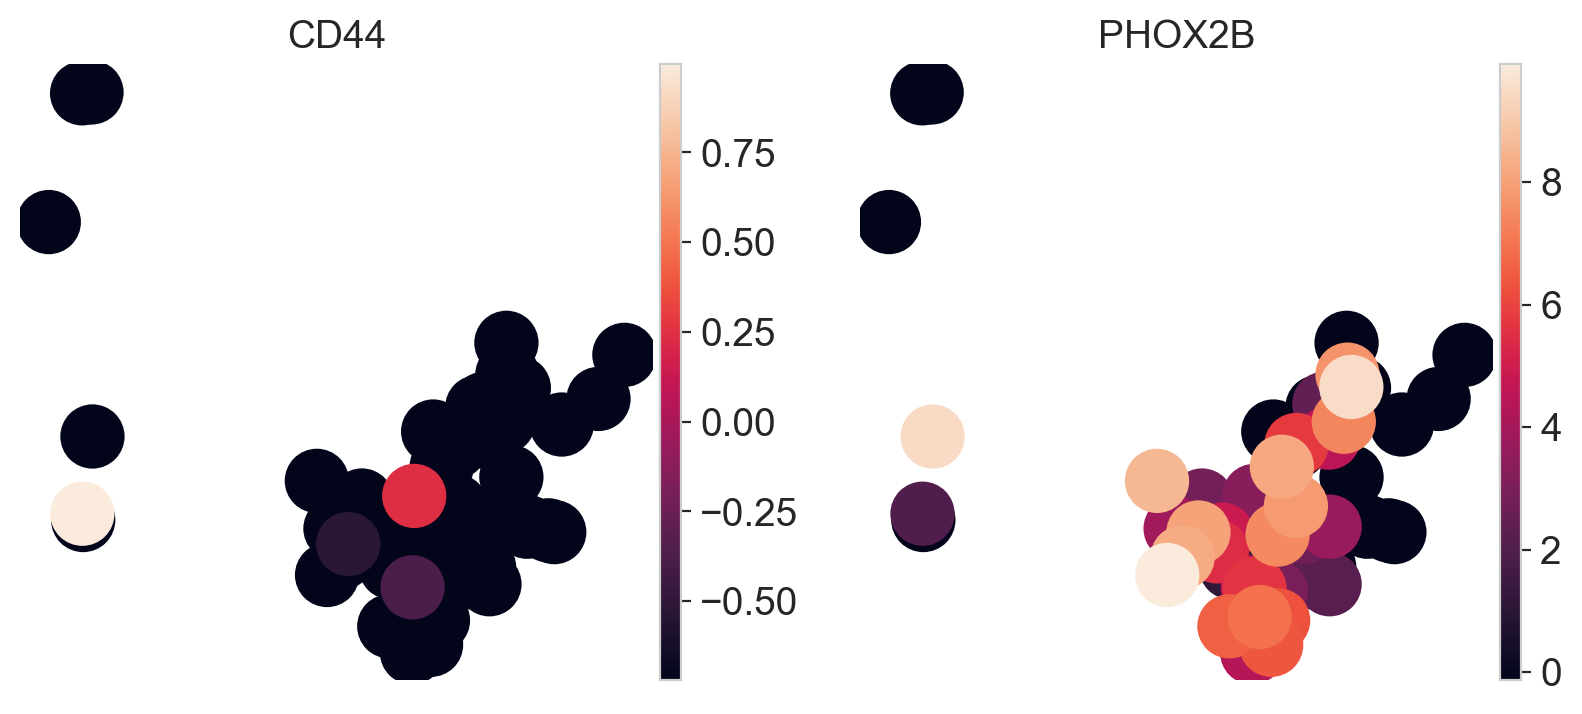

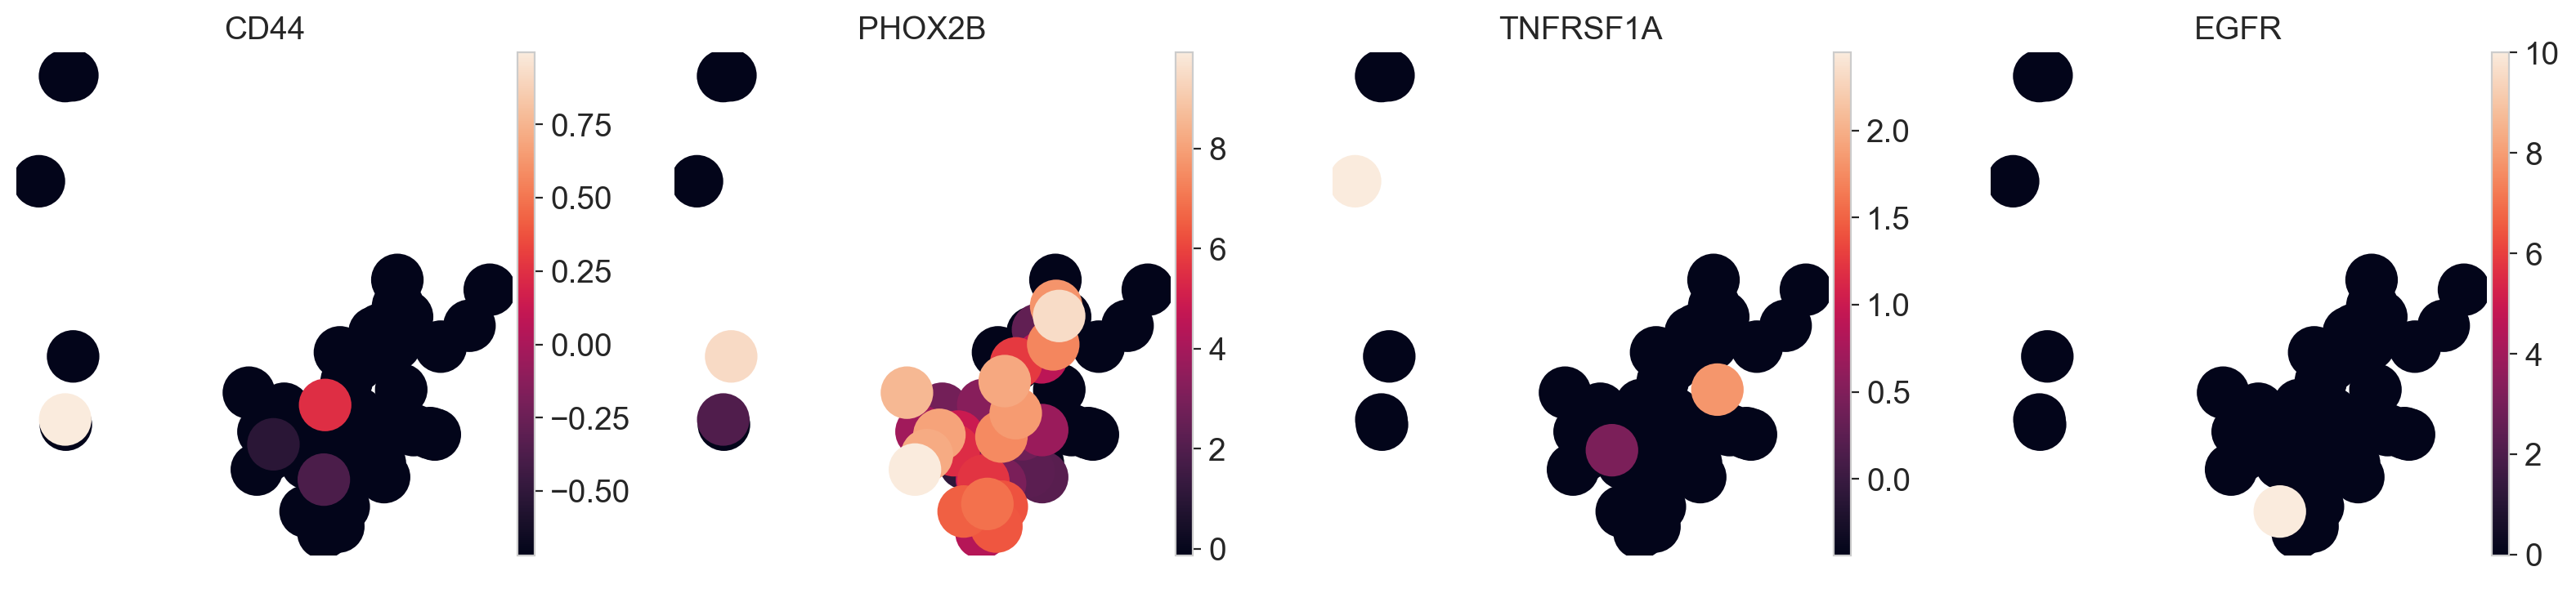

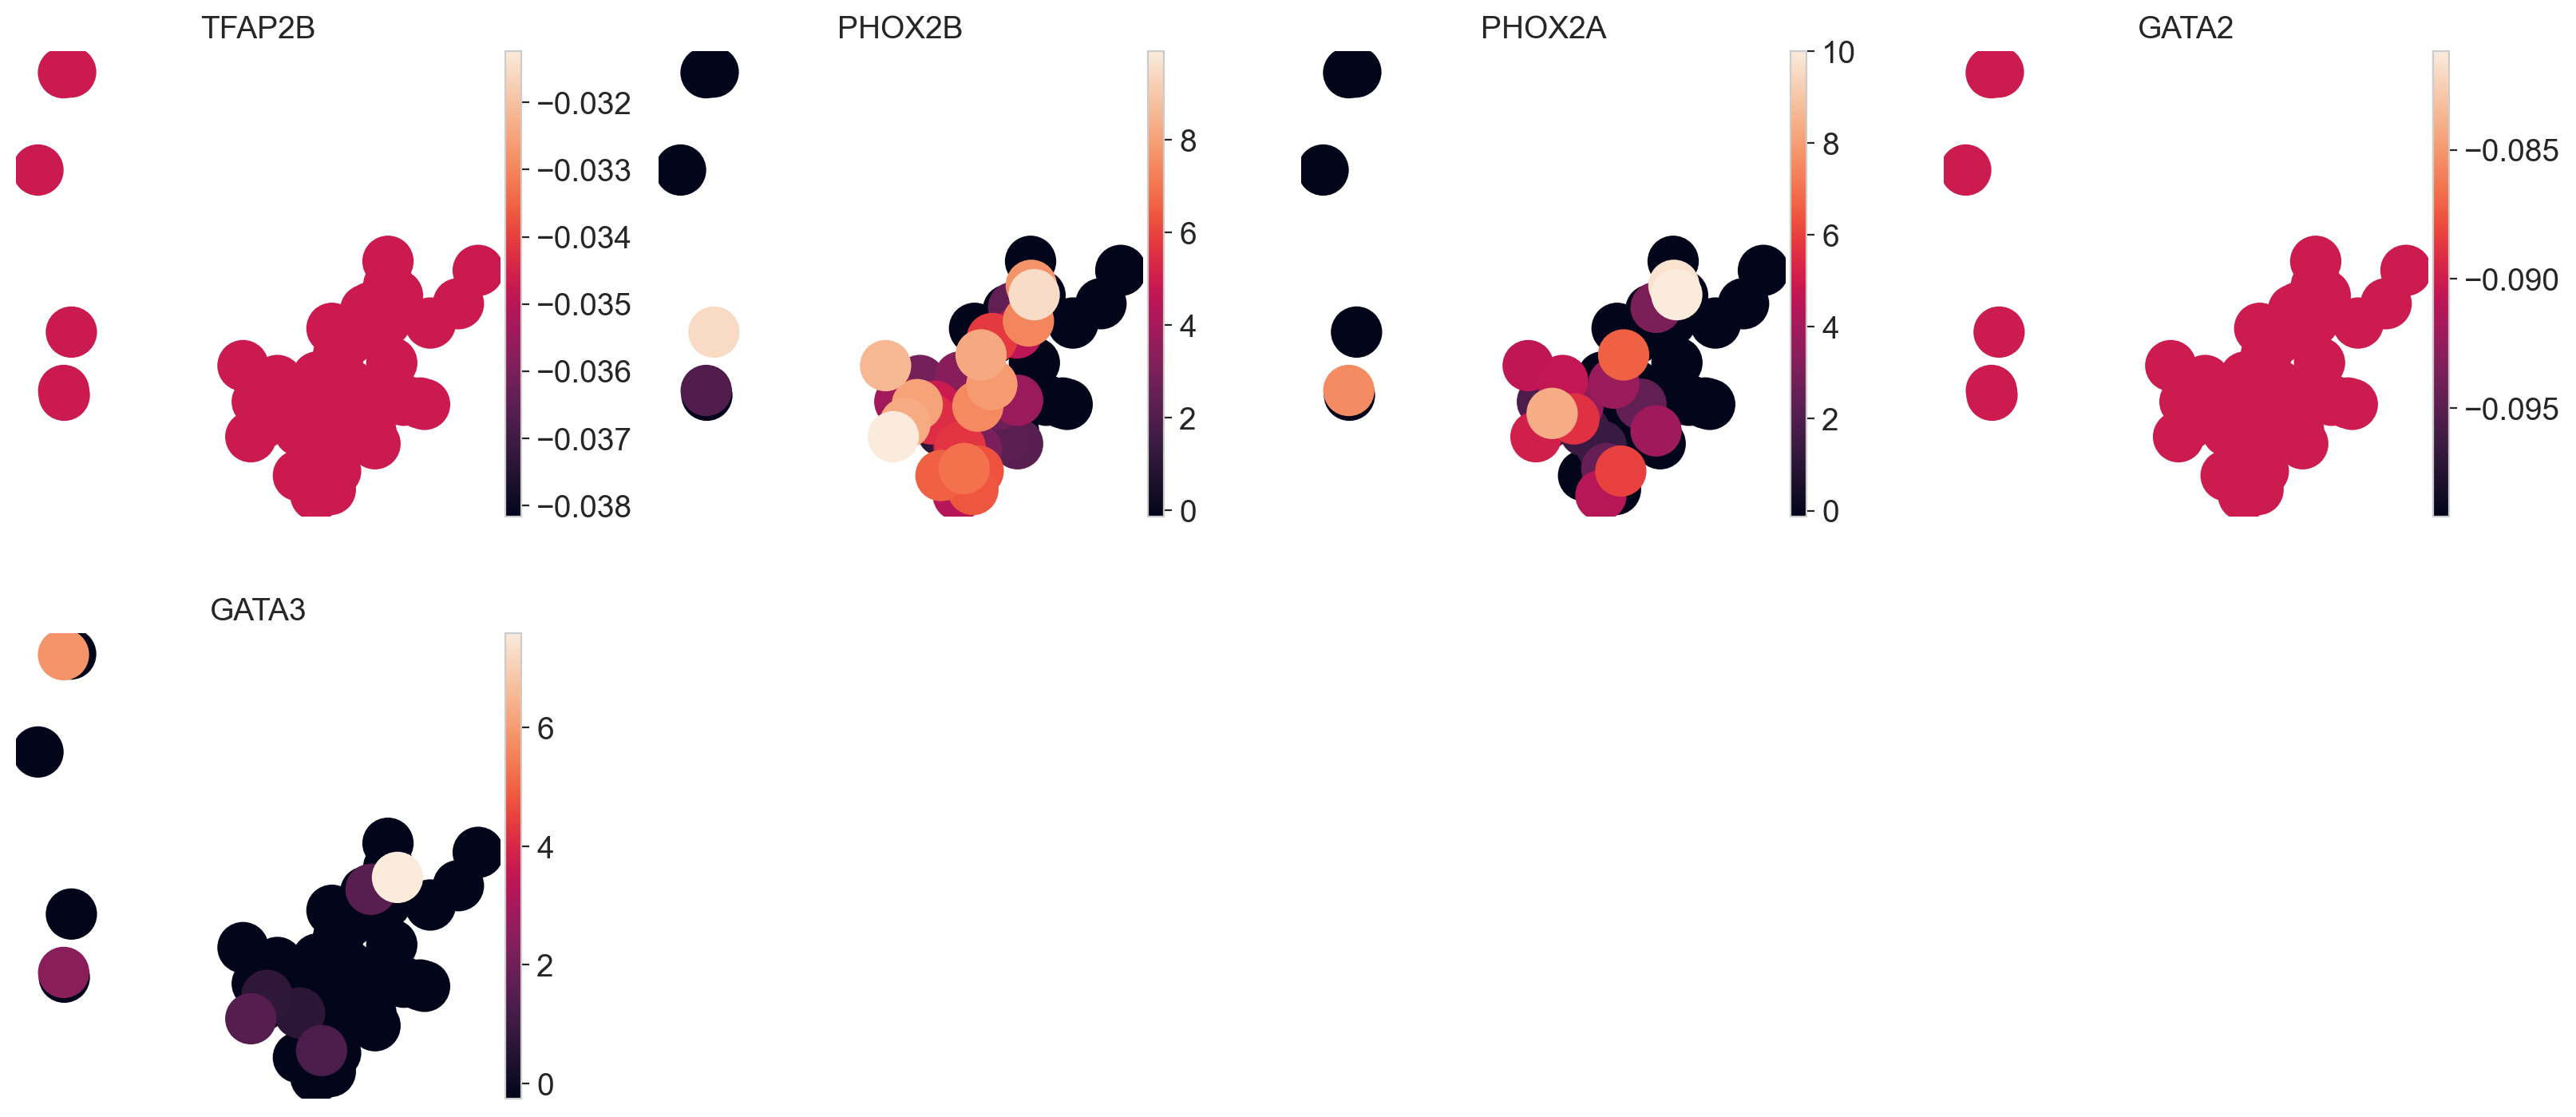

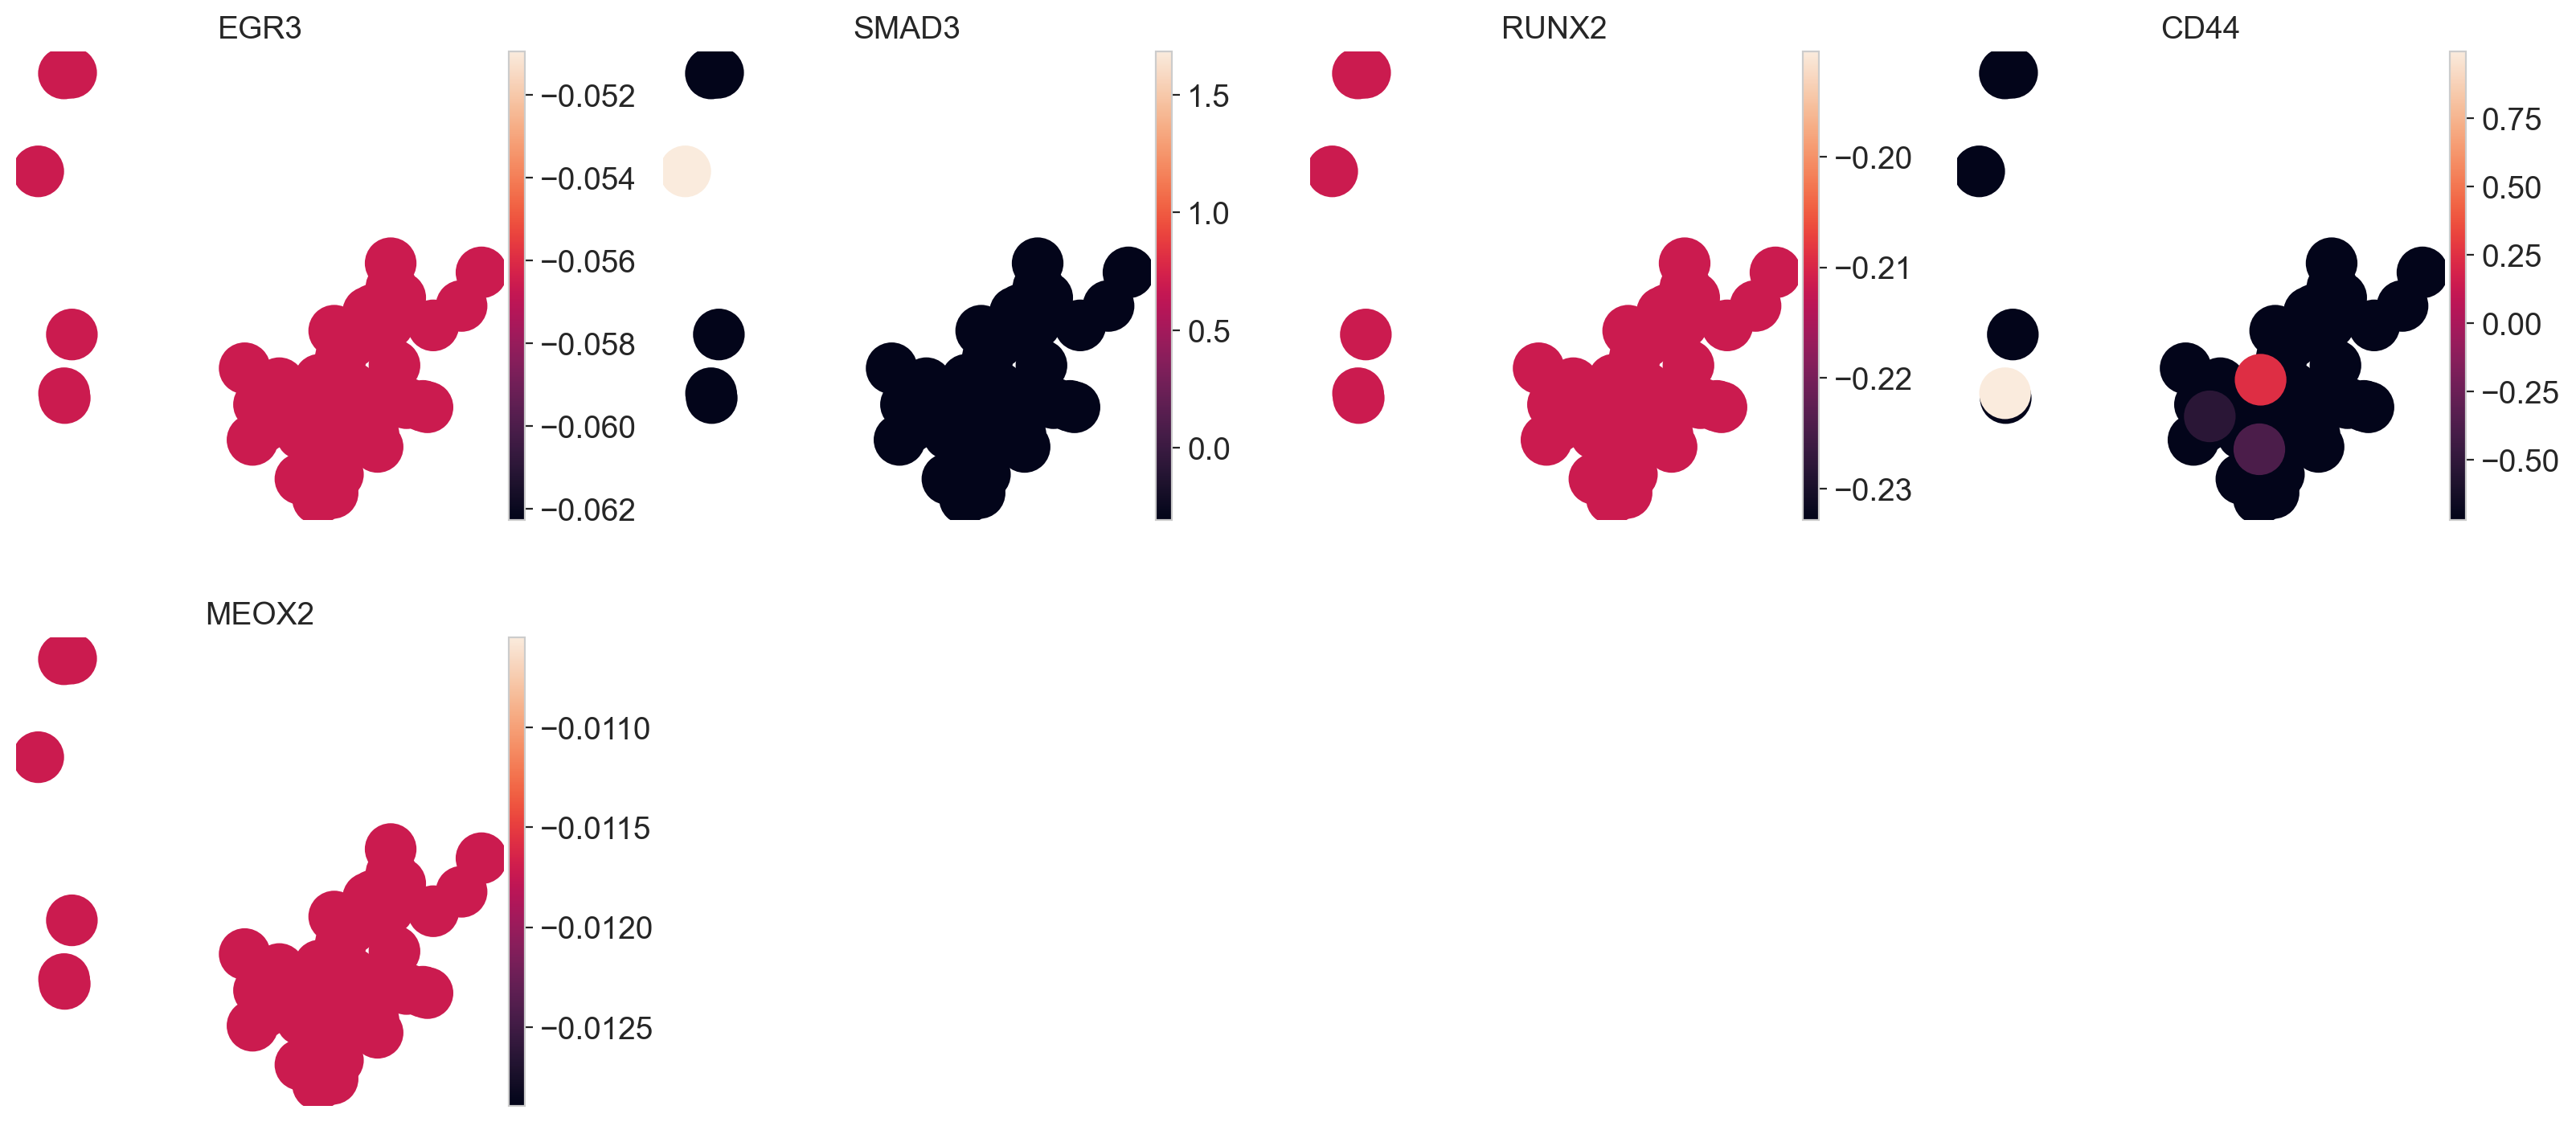

In [10]:
### Check the NOR and ADR signatures in the tumor cells ###

# 1) Subset the AnnData to only include Tumor cells
tumor_adata = adata[adata.obs["cell2"] == "Tumor"].copy()

# 2) Plot the expression of your genes of interest (e.g. "GeneA", "GeneB")
sc.pl.umap(tumor_adata, color=["CD44", "PHOX2B"])

# 3) Plot the expression of your genes of interest (e.g. "GeneA", "GeneB")

## PHOX2B ADR population
## CD44 MES
## TNFRSF1A AND EGFR Bridge to MES

sc.pl.umap(tumor_adata, color=["CD44", "PHOX2B", "TNFRSF1A", "EGFR"])

## NOR genes from https://www.nature.com/articles/s41467-023-38239-5/figures/4
sc.pl.umap(tumor_adata, color=["TFAP2B", "PHOX2B", "PHOX2A", "GATA2", "GATA3"])


## MES genes from https://www.nature.com/articles/s41467-023-38239-5/figures/4

sc.pl.umap(tumor_adata, color=["EGR3", "SMAD3", "RUNX2", "CD44", "MEOX2"])

Fitting GMM with 13 components...
Calculating entropy...
Added 'GMM_probabilities' to embed_adata.obsm
Added 'GMM_entropy' to embed_adata.obs
Added 'GMM_cluster' (dominant cluster) to embed_adata.obs

Done with GMM and entropy calculation.

--- Starting Visualization (using embedding: 'X_umap') ---
Plotting dominant GMM clusters on X_umap...


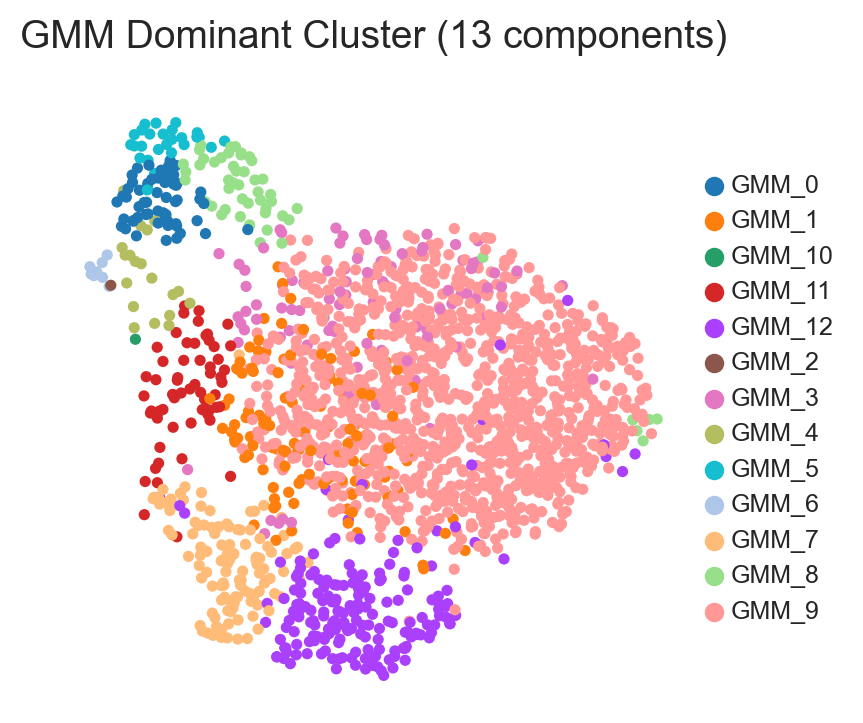

Plotting GMM entropy on X_umap...


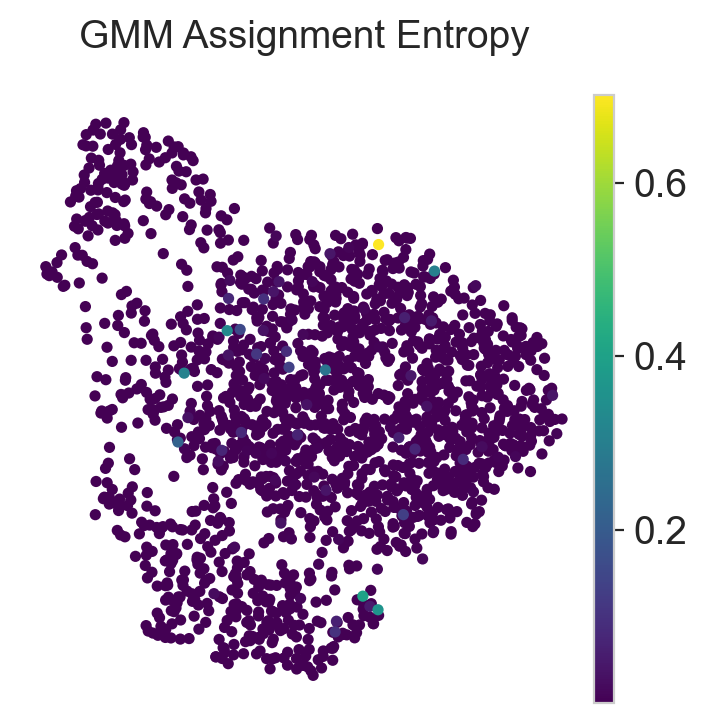

Plotting clusters and entropy side-by-side on X_umap...


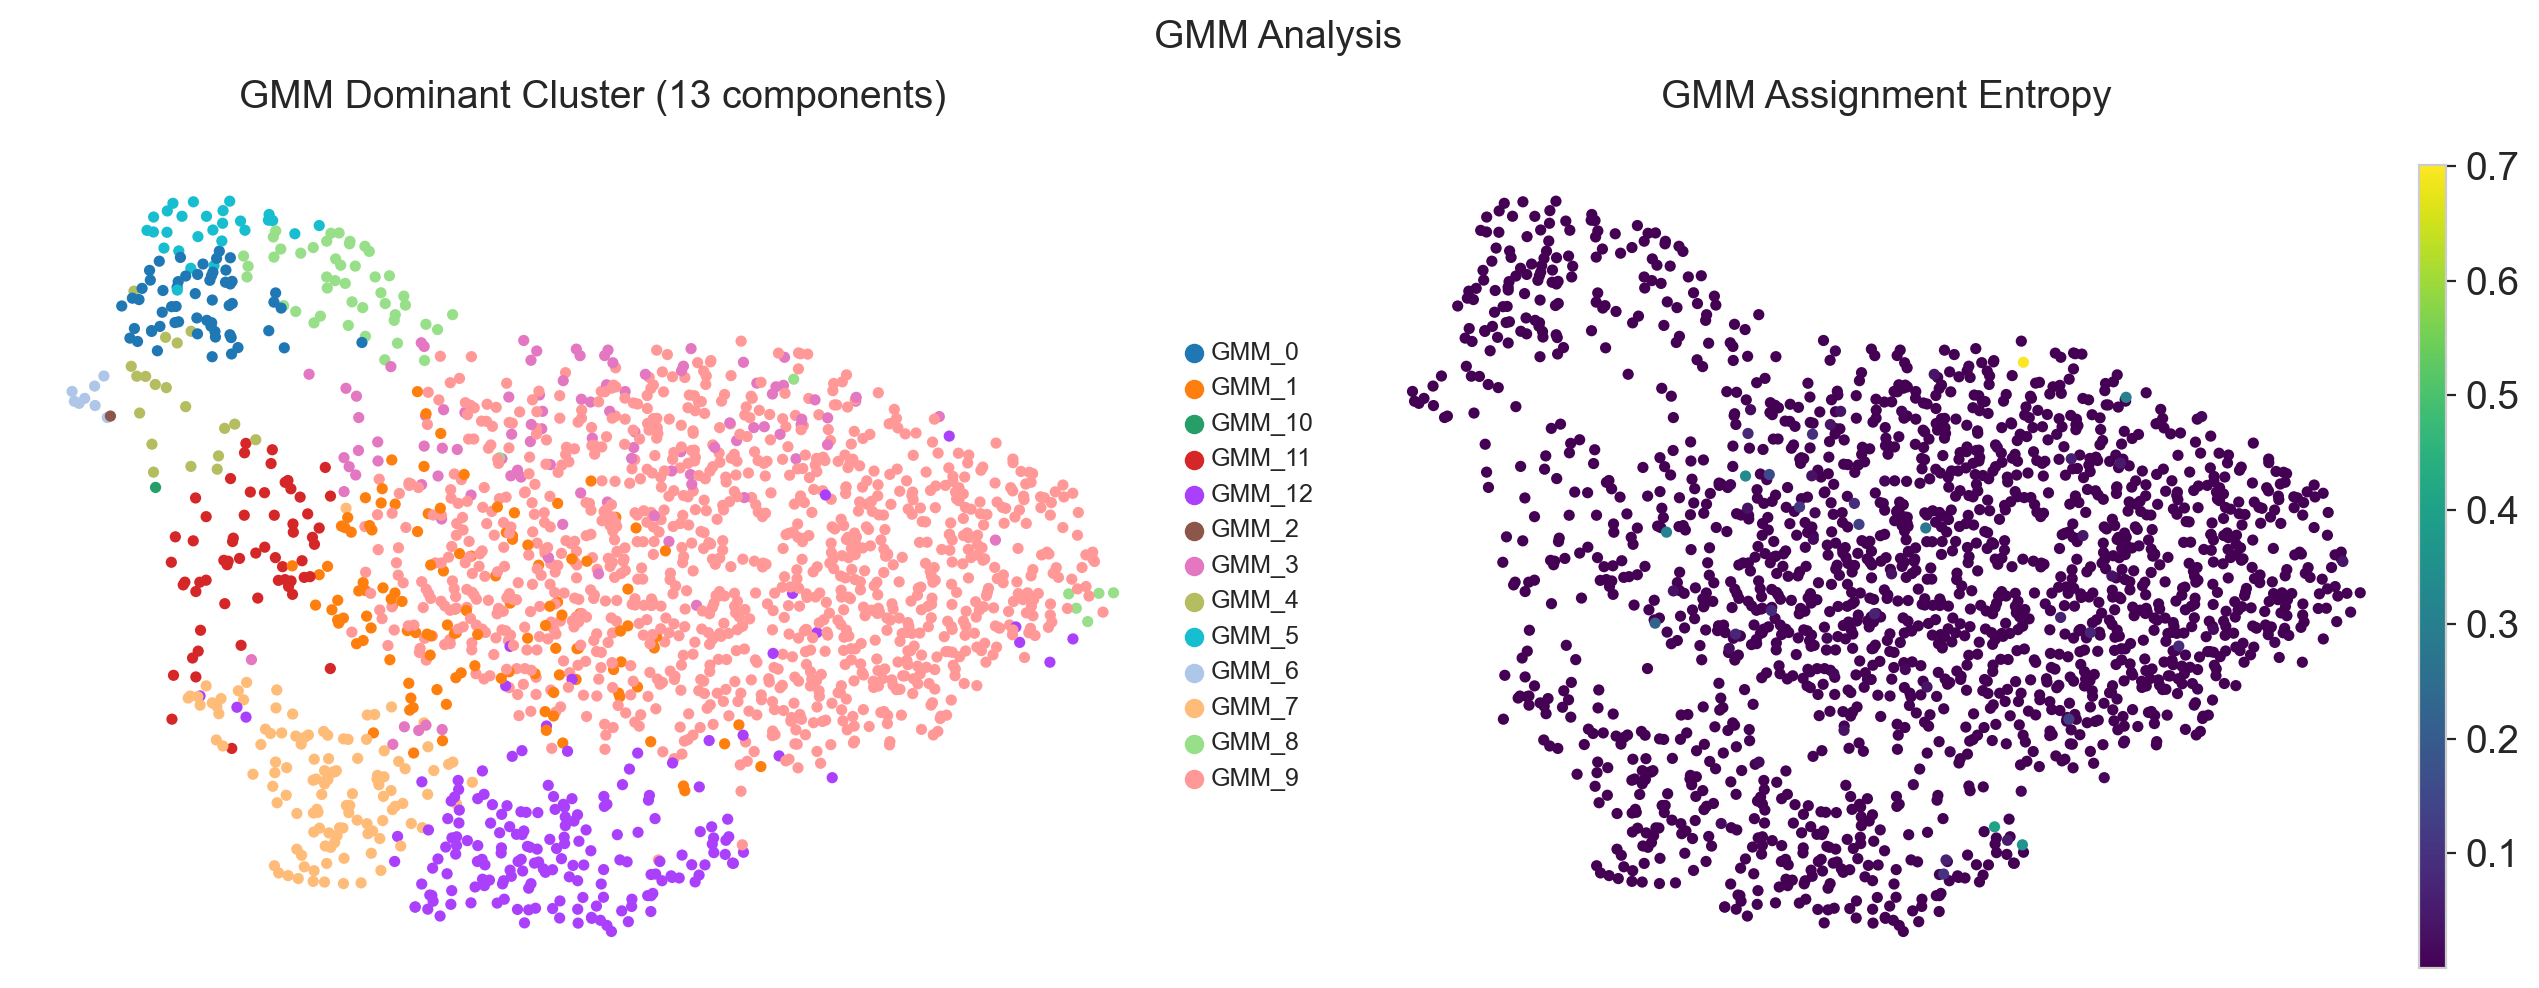


--- Visualization Complete ---


In [11]:
# --- GMM Soft Clustering and Entropy Calculation ---
from sklearn.mixture import GaussianMixture
from scipy.stats import entropy
import numpy as np
import matplotlib.pyplot as plt  # <<< ENSURE THIS IS IMPORTED
import seaborn as sns 

n_clusters = 13  # Specify the desired number of clusters (components) - adjust as needed


embeddings = embed_adata.obsm['CancerGPT']
print(f"Fitting GMM with {n_clusters} components...")
gmm = GaussianMixture(n_components=n_clusters,
                      random_state=random_seed,
                      covariance_type='full') # 'full' is default, other options: 'tied', 'diag', 'spherical'
gmm.fit(embeddings)


gmm_probabilities = gmm.predict_proba(embeddings)
print("Calculating entropy...")
# Entropy H(p) = - sum(p_i * log2(p_i))
# Add a small epsilon to avoid log(0)
epsilon = 1e-9
cell_entropy = entropy(gmm_probabilities.T + epsilon, base=2)

# 6. Store results in AnnData object
embed_adata.obsm['GMM_probabilities'] = gmm_probabilities
print("Added 'GMM_probabilities' to embed_adata.obsm")
embed_adata.obs['GMM_entropy'] = cell_entropy
print("Added 'GMM_entropy' to embed_adata.obs")

# --- Add Dominant Cluster Assignment ---
# Find the cluster index with the highest probability for each cell
dominant_cluster = np.argmax(gmm_probabilities, axis=1)
# Store as categorical strings for better plotting with scanpy
embed_adata.obs['GMM_cluster'] = [f'GMM_{c}' for c in dominant_cluster]
embed_adata.obs['GMM_cluster'] = embed_adata.obs['GMM_cluster'].astype('category')
print("Added 'GMM_cluster' (dominant cluster) to embed_adata.obs")

print("\nDone with GMM and entropy calculation.")

embedding_key = 'X_umap'
# --- Visualization ---
print(f"\n--- Starting Visualization (using embedding: '{embedding_key}') ---")

# Configure plot settings (optional, but recommended)
sc.settings.set_figure_params(dpi=100, facecolor='white', frameon=False)
sns.set_style("whitegrid") # Or "white", "ticks", etc.

# --- Titles ---
title_cluster = f'GMM Dominant Cluster ({n_clusters} components)'
title_entropy = 'GMM Assignment Entropy'
title_y_position = 1.05 # Adjust this value to move title further up (e.g., 1.05) or down (e.g., 1.01)

# 1. Visualize Dominant GMM Clusters
print(f"Plotting dominant GMM clusters on {embedding_key}...")
fig1, ax1 = plt.subplots()
sc.pl.embedding(embed_adata,
                basis=embedding_key,
                color='GMM_cluster',
                legend_loc='right margin',
                legend_fontsize=9,
                ax=ax1,
                show=False)

# Set title manually using matplotlib with adjusted vertical position
ax1.set_title(title_cluster, y=title_y_position)
# plt.savefig(f'gmm_clusters_{embedding_key}.png', dpi=output_fig_dpi, bbox_inches='tight')
plt.show()

# 2. Visualize GMM Assignment Entropy
print(f"Plotting GMM entropy on {embedding_key}...")
fig2, ax2 = plt.subplots()
sc.pl.embedding(embed_adata,
                basis=embedding_key,
                color='GMM_entropy',

                cmap='viridis',
                colorbar_loc='right',
                ax=ax2,
                show=False)
# Set title manually using matplotlib with adjusted vertical position
ax2.set_title(title_entropy, y=title_y_position)
# plt.savefig(f'gmm_entropy_{embedding_key}.png', dpi=output_fig_dpi, bbox_inches='tight')
plt.show()

# 3. Visualize Both Side-by-Side (Optional)
print(f"Plotting clusters and entropy side-by-side on {embedding_key}...")
fig3, axes = plt.subplots(1, 2, figsize=(13, 5))

# Plot Clusters on the left
sc.pl.embedding(embed_adata,
                basis=embedding_key,
                color='GMM_cluster',
                 # --- MODIFICATION START ---
                title=None, # Remove title from scanpy call
                # --- MODIFICATION END ---
                legend_loc='right margin',
                legend_fontsize=9,
                ax=axes[0],
                show=False)
# --- MODIFICATION START ---
axes[0].set_title(title_cluster, y=title_y_position) # Set title manually
# --- MODIFICATION END ---
axes[0].set_xlabel(f"{embedding_key.split('_')[-1].upper()} 1")
axes[0].set_ylabel(f"{embedding_key.split('_')[-1].upper()} 2")

# Plot Entropy on the right
sc.pl.embedding(embed_adata,
                basis=embedding_key,
                color='GMM_entropy',
                 # --- MODIFICATION START ---
                title=None, # Remove title from scanpy call
                # --- MODIFICATION END ---
                cmap='viridis',
                colorbar_loc='right',
                ax=axes[1],
                show=False)

axes[1].set_title(title_entropy, y=title_y_position) # Set title manually
axes[1].set_xlabel(f"{embedding_key.split('_')[-1].upper()} 1")
axes[1].set_ylabel(f"{embedding_key.split('_')[-1].upper()} 2")


# Use tight_layout *after* setting titles
plt.tight_layout(rect=[0, 0, 1, 0.97]) # Add rect to potentially leave space for suptitle if needed, adjust top value (0.97) if titles still overlap
fig3.suptitle("GMM Analysis", fontsize=14, y=0.99) # Example suptitle

# plt.savefig(f'gmm_clusters_entropy_{embedding_key}_combined.png', dpi=output_fig_dpi, bbox_inches='tight')
plt.show()

print("\n--- Visualization Complete ---")

In [7]:
# --- 3a: K-Means Clustering ---
# Decide on the number of clusters for k-means.
import pandas as pd
from sklearn.cluster import KMeans

n_clusters_kmeans = n_clusters 
print(f"Running K-Means with {n_clusters_kmeans} clusters on '{embedding_key}' embeddings...")
kmeans = KMeans(n_clusters=n_clusters_kmeans, random_state=random_seed, n_init=10)
kmeans_labels = kmeans.fit_predict(embeddings)
embed_adata.obs['kmeans'] = pd.Categorical([f'KMeans_{c}' for c in kmeans_labels])
print(f"Stored K-Means results in embed_adata.obs['kmeans']")


# --- 3b: Louvain Clustering ---
# Louvain uses the neighbors graph computed earlier
# Resolution parameter influences the number of clusters found. Tune as needed.
print("Running Louvain clustering...")
sc.tl.louvain(embed_adata, random_state=random_seed, key_added='louvain') # Default resolution=1.0
print(f"Stored Louvain results in embed_adata.obs['louvain']")
# Visualize number of clusters found
print(f"Found {len(embed_adata.obs['louvain'].cat.categories)} Louvain clusters.")

# --- 3c: Leiden Clustering ---
# Leiden also uses the neighbors graph and is generally preferred over Louvain
print("Running Leiden clustering...")
sc.tl.leiden(embed_adata, random_state=random_seed, key_added='leiden') # Default resolution=1.0
print(f"Stored Leiden results in embed_adata.obs['leiden']")
# Visualize number of clusters found
print(f"Found {len(embed_adata.obs['leiden'].cat.categories)} Leiden clusters.")


Running K-Means with 13 clusters on 'X_umap' embeddings...
Stored K-Means results in embed_adata.obs['kmeans']
Running Louvain clustering...
Stored Louvain results in embed_adata.obs['louvain']
Found 7 Louvain clusters.
Running Leiden clustering...


/var/folders/m2/lbk735w547j5jf8nwvk8vnj40000gn/T/ipykernel_59979/2957850872.py:26: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(embed_adata, random_state=random_seed, key_added='leiden') # Default resolution=1.0


Stored Leiden results in embed_adata.obs['leiden']
Found 9 Leiden clusters.



--- Starting Evaluation Against Known Cell Labels ---


--- 1. Clustering Evaluation Metrics (vs 'cell1') ---

Evaluating: GMM_cluster
  Adjusted Rand Index (ARI): 0.2914
  Normalized Mutual Info (NMI): 0.3390
  Homogeneity: 0.2993
  Completeness: 0.3907
  V-Measure: 0.3390

Evaluating: kmeans
  Adjusted Rand Index (ARI): 0.1467
  Normalized Mutual Info (NMI): 0.2752
  Homogeneity: 0.2691
  Completeness: 0.2816
  V-Measure: 0.2752

Evaluating: louvain
  Adjusted Rand Index (ARI): 0.1510
  Normalized Mutual Info (NMI): 0.2737
  Homogeneity: 0.2699
  Completeness: 0.2776
  V-Measure: 0.2737

Evaluating: leiden
  Adjusted Rand Index (ARI): 0.1570
  Normalized Mutual Info (NMI): 0.2860
  Homogeneity: 0.2971
  Completeness: 0.2756
  V-Measure: 0.2860

--- Metrics Summary ---
                  ARI       NMI  Homogeneity  Completeness  V-Measure
GMM_cluster  0.291405  0.338952     0.299335      0.390656   0.338952
kmeans       0.146695  0.275191     0.269101      0.281562   0.275191
louvain 

/var/folders/m2/lbk735w547j5jf8nwvk8vnj40000gn/T/ipykernel_59979/454821130.py:80: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not pd.api.types.is_categorical_dtype(true_labels):


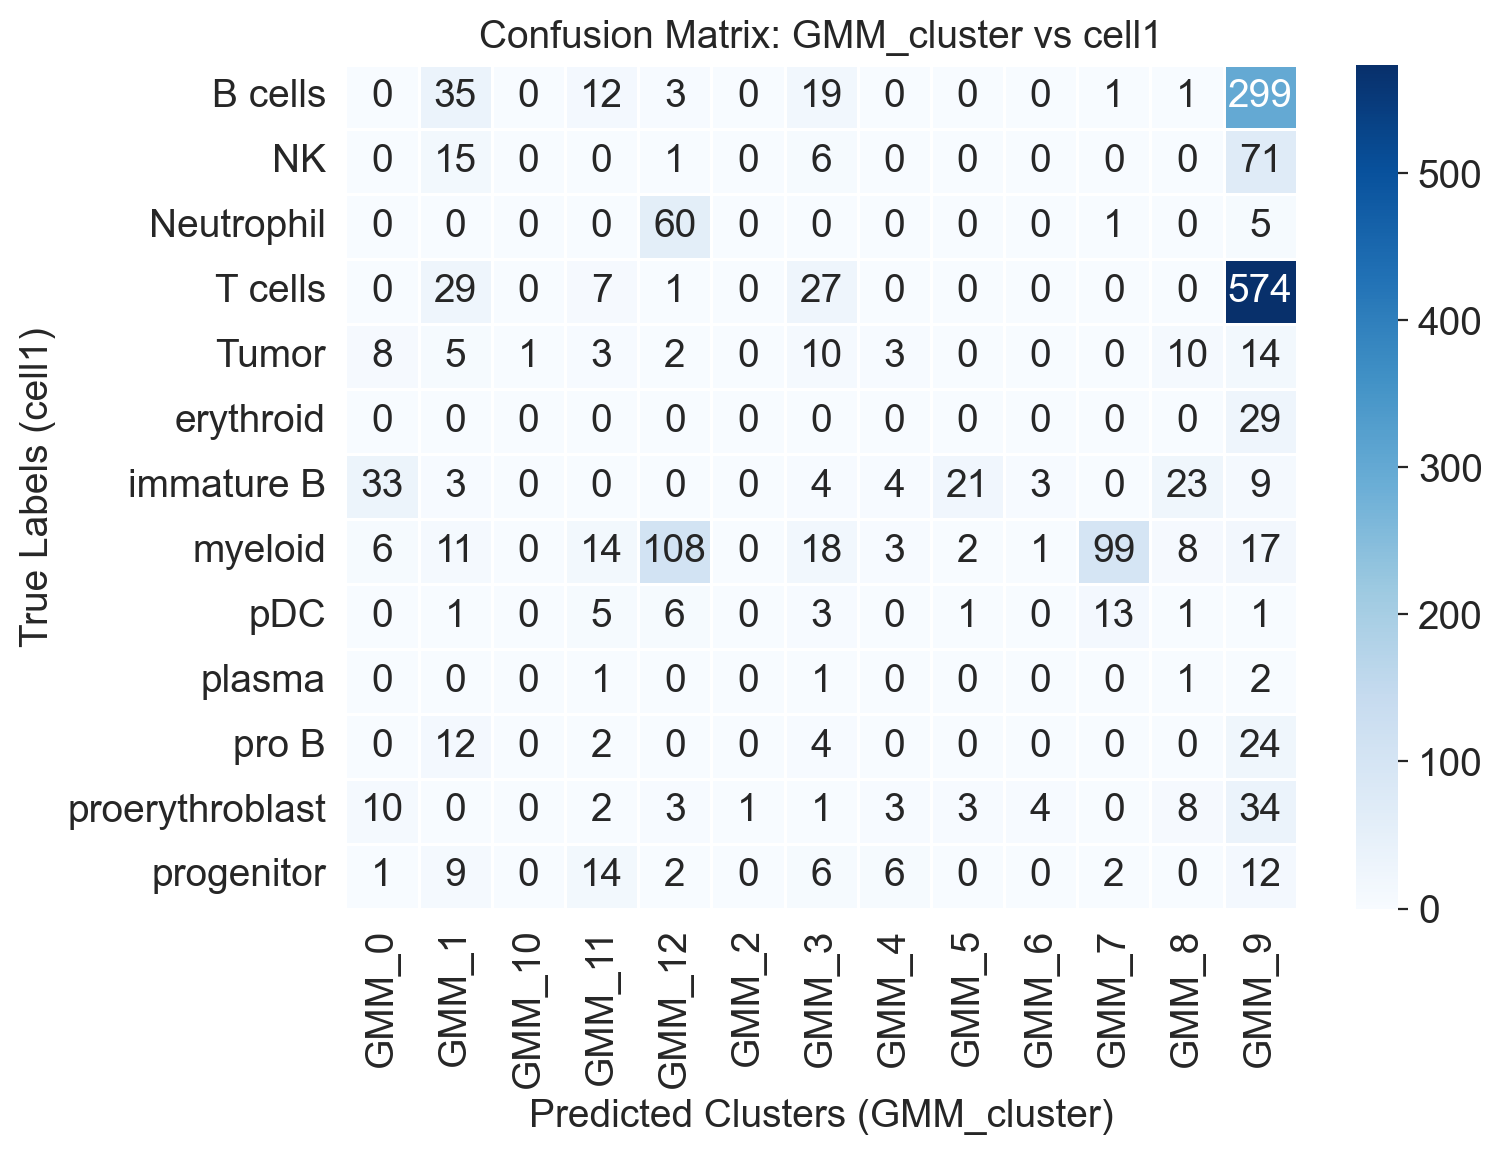


Generating Confusion Matrix for: kmeans


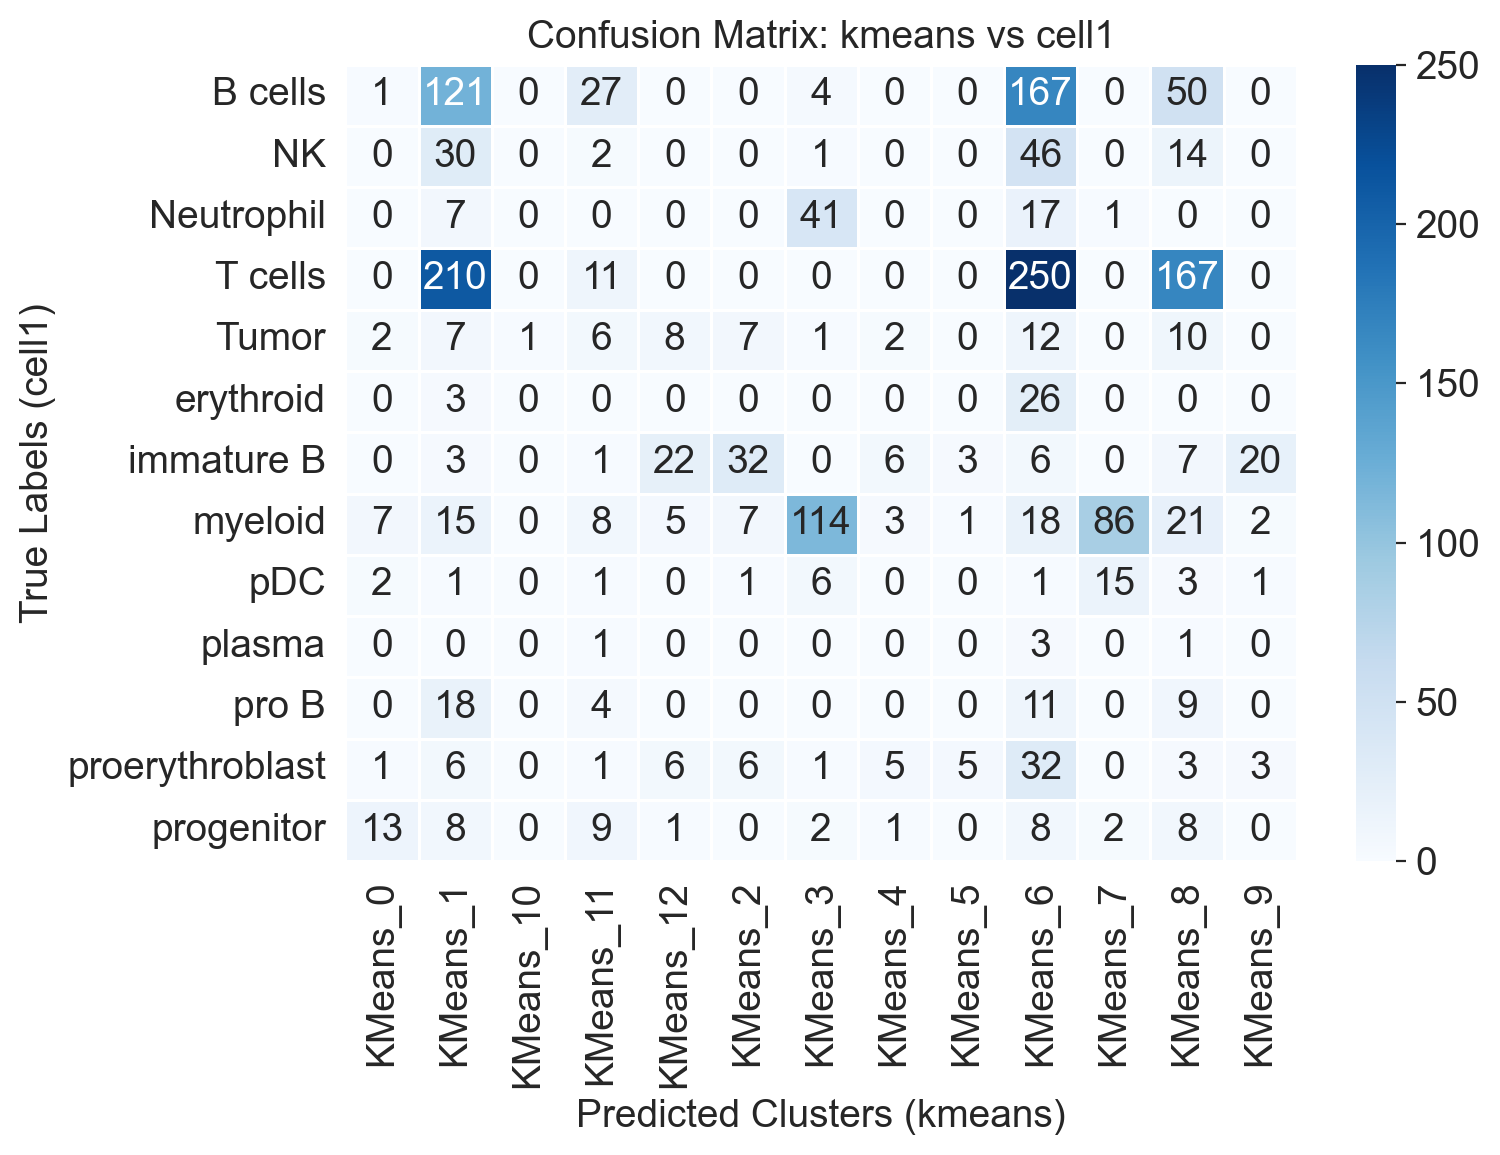


Generating Confusion Matrix for: louvain


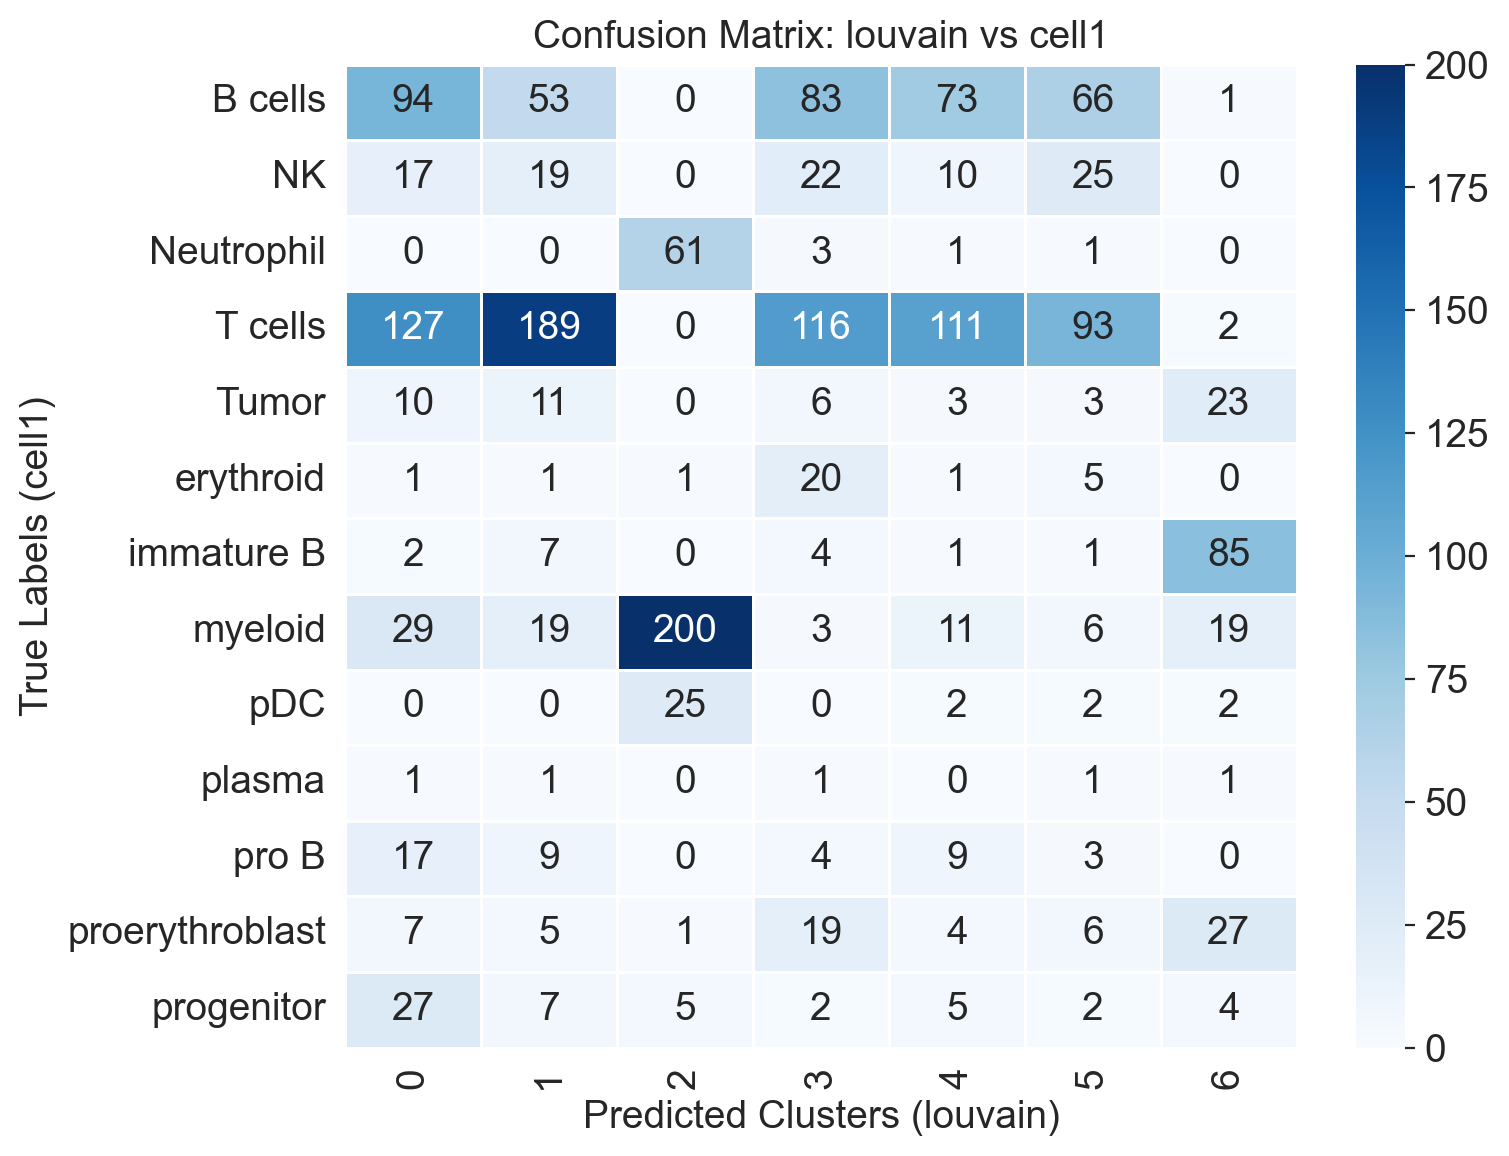


Generating Confusion Matrix for: leiden


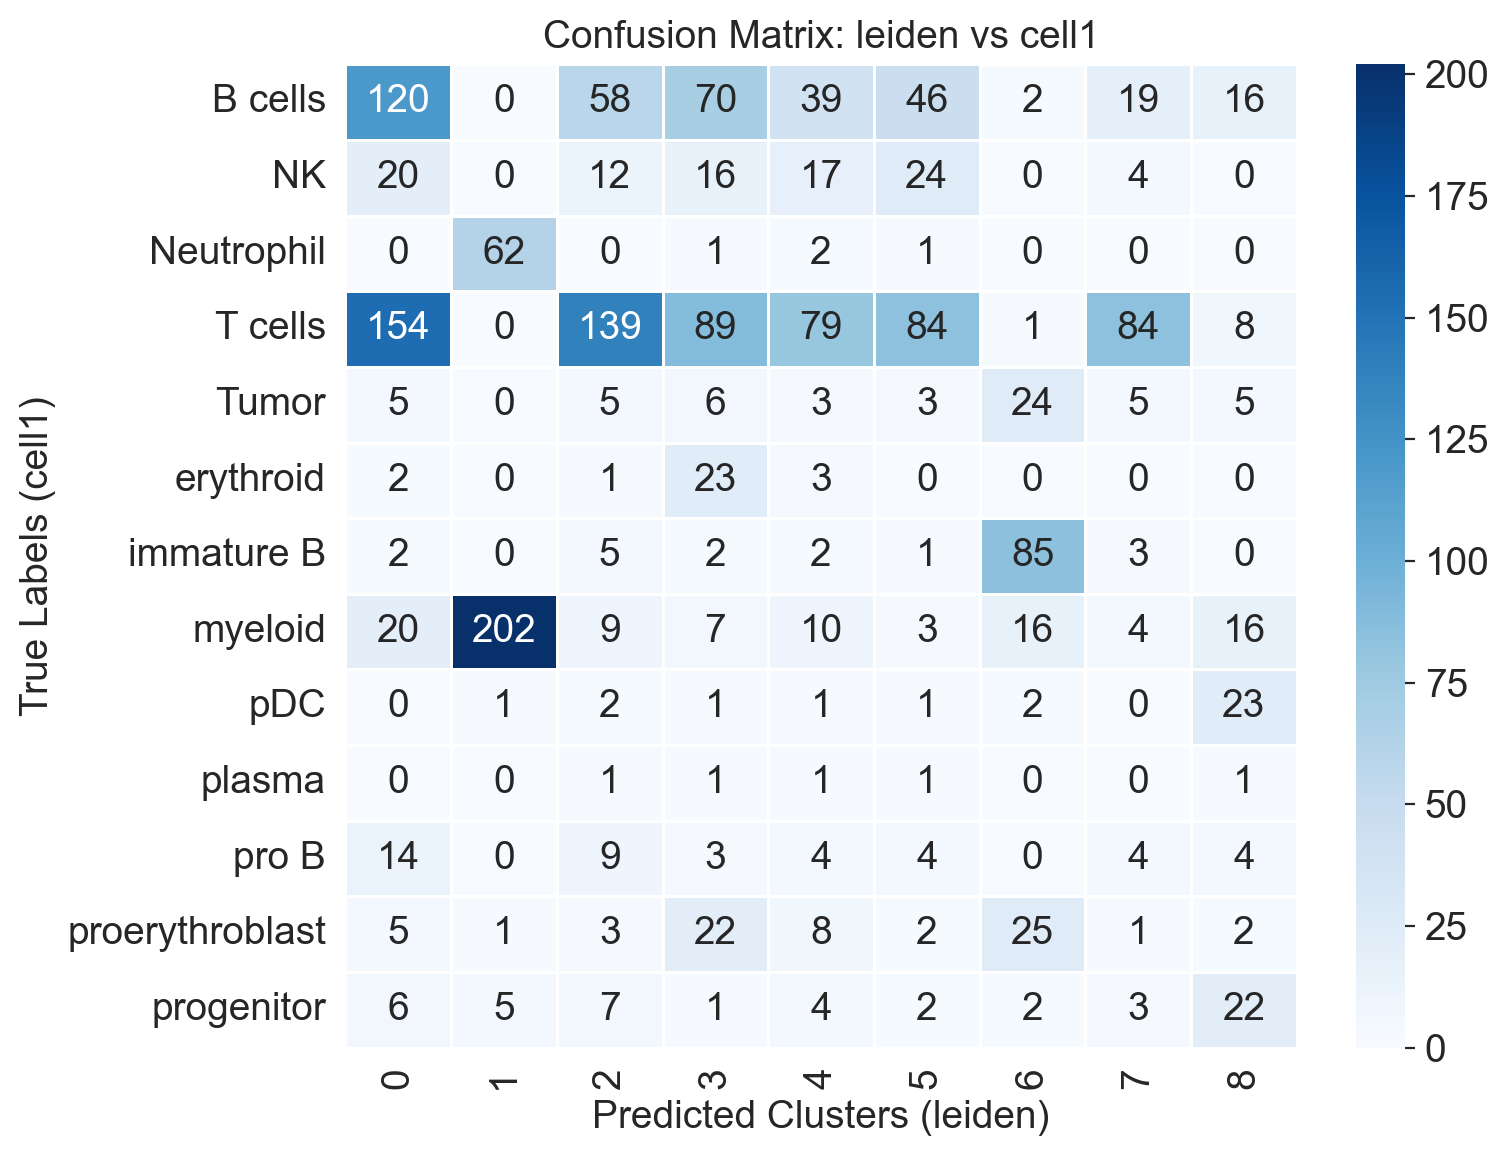


--- 3. Cluster Composition Bar Plots ---

Generating Composition Plot for: GMM_cluster


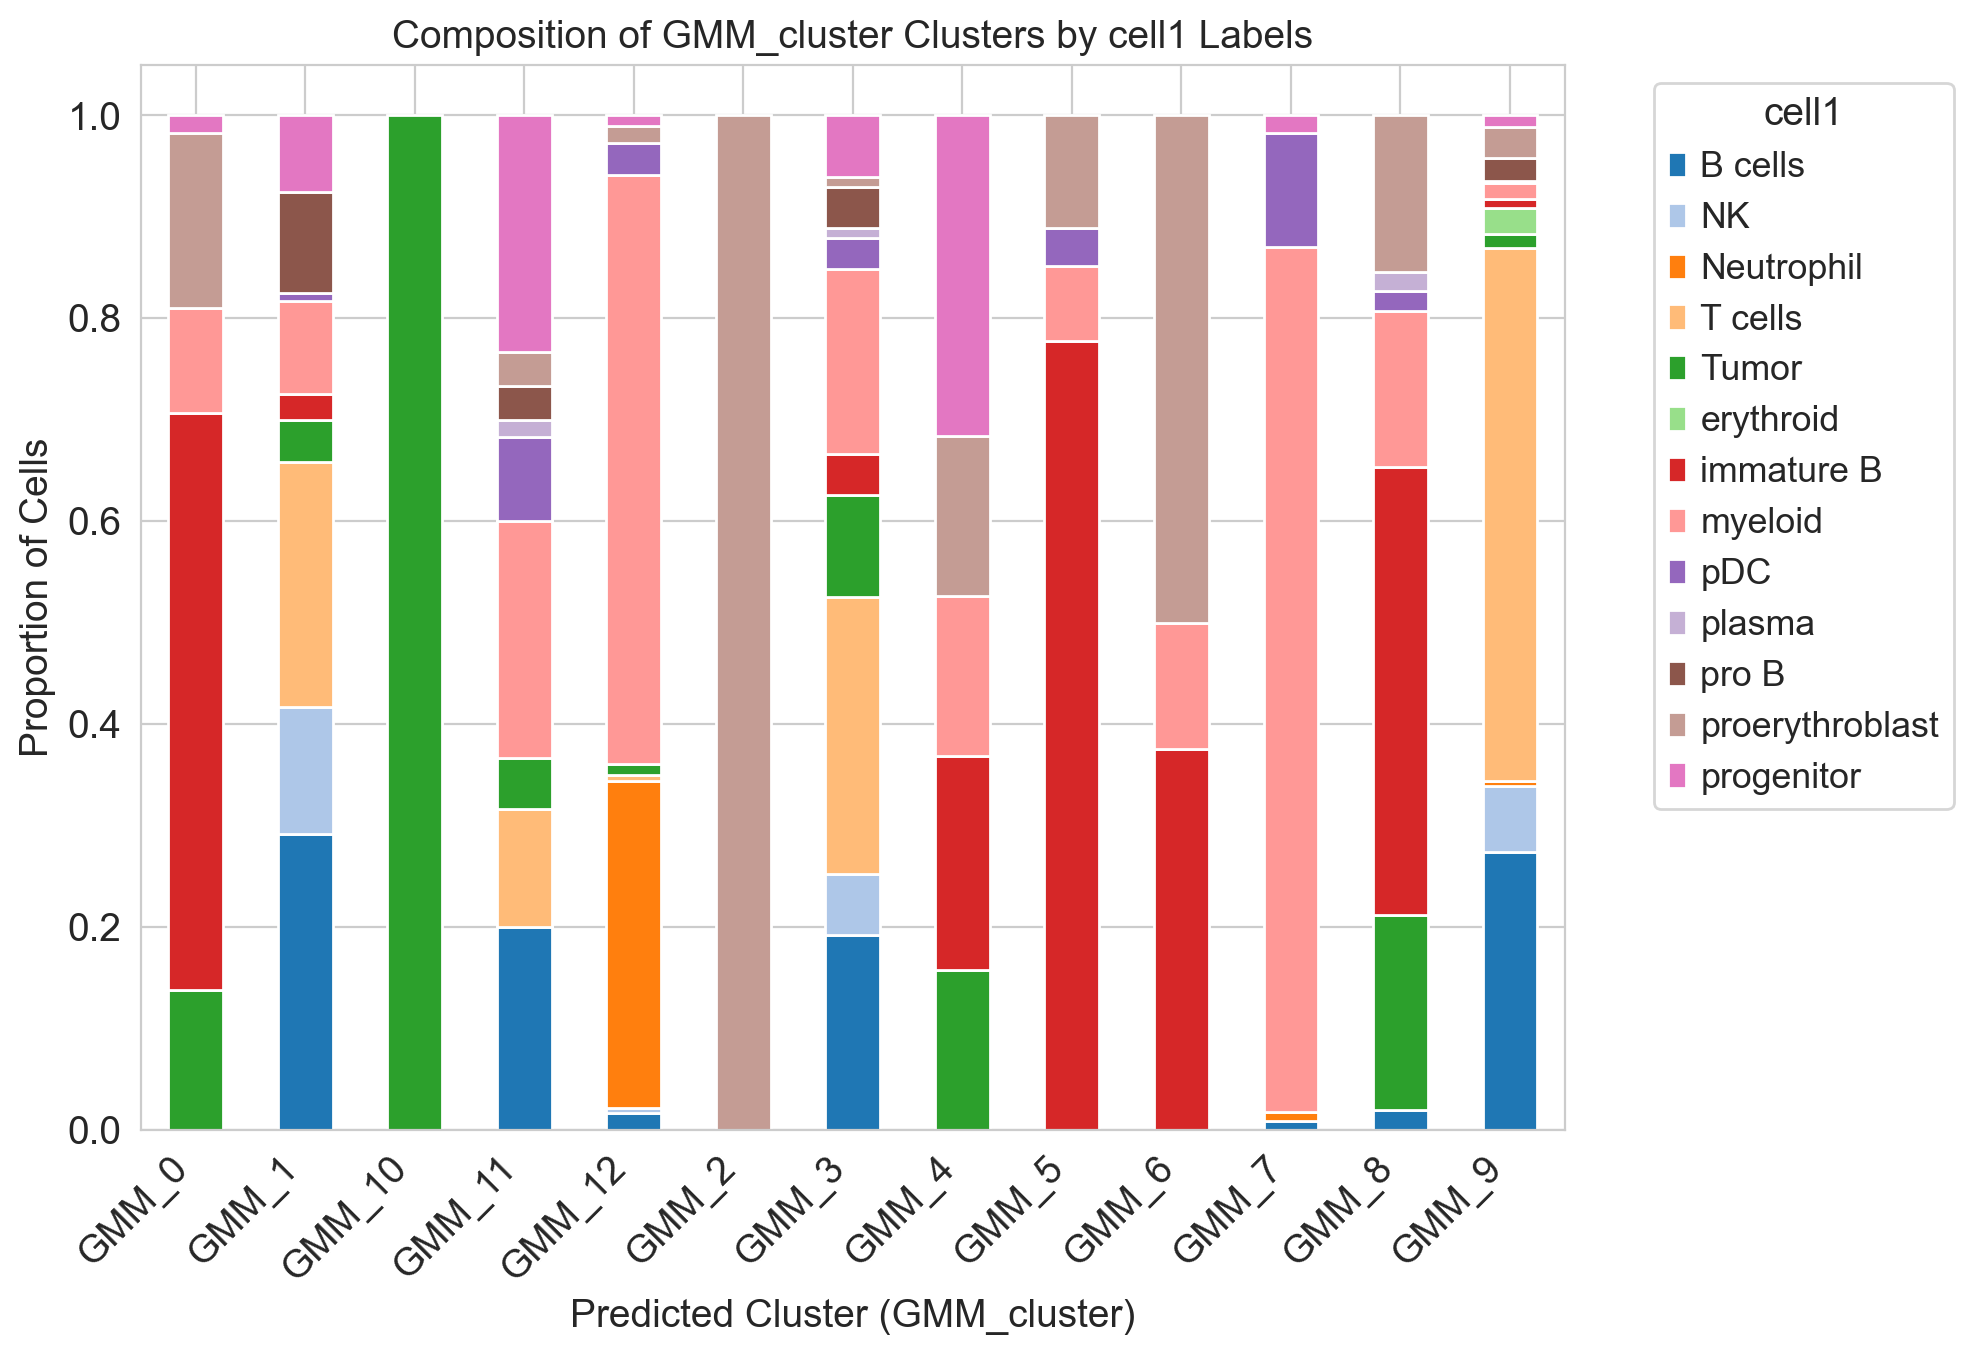


Generating Composition Plot for: kmeans


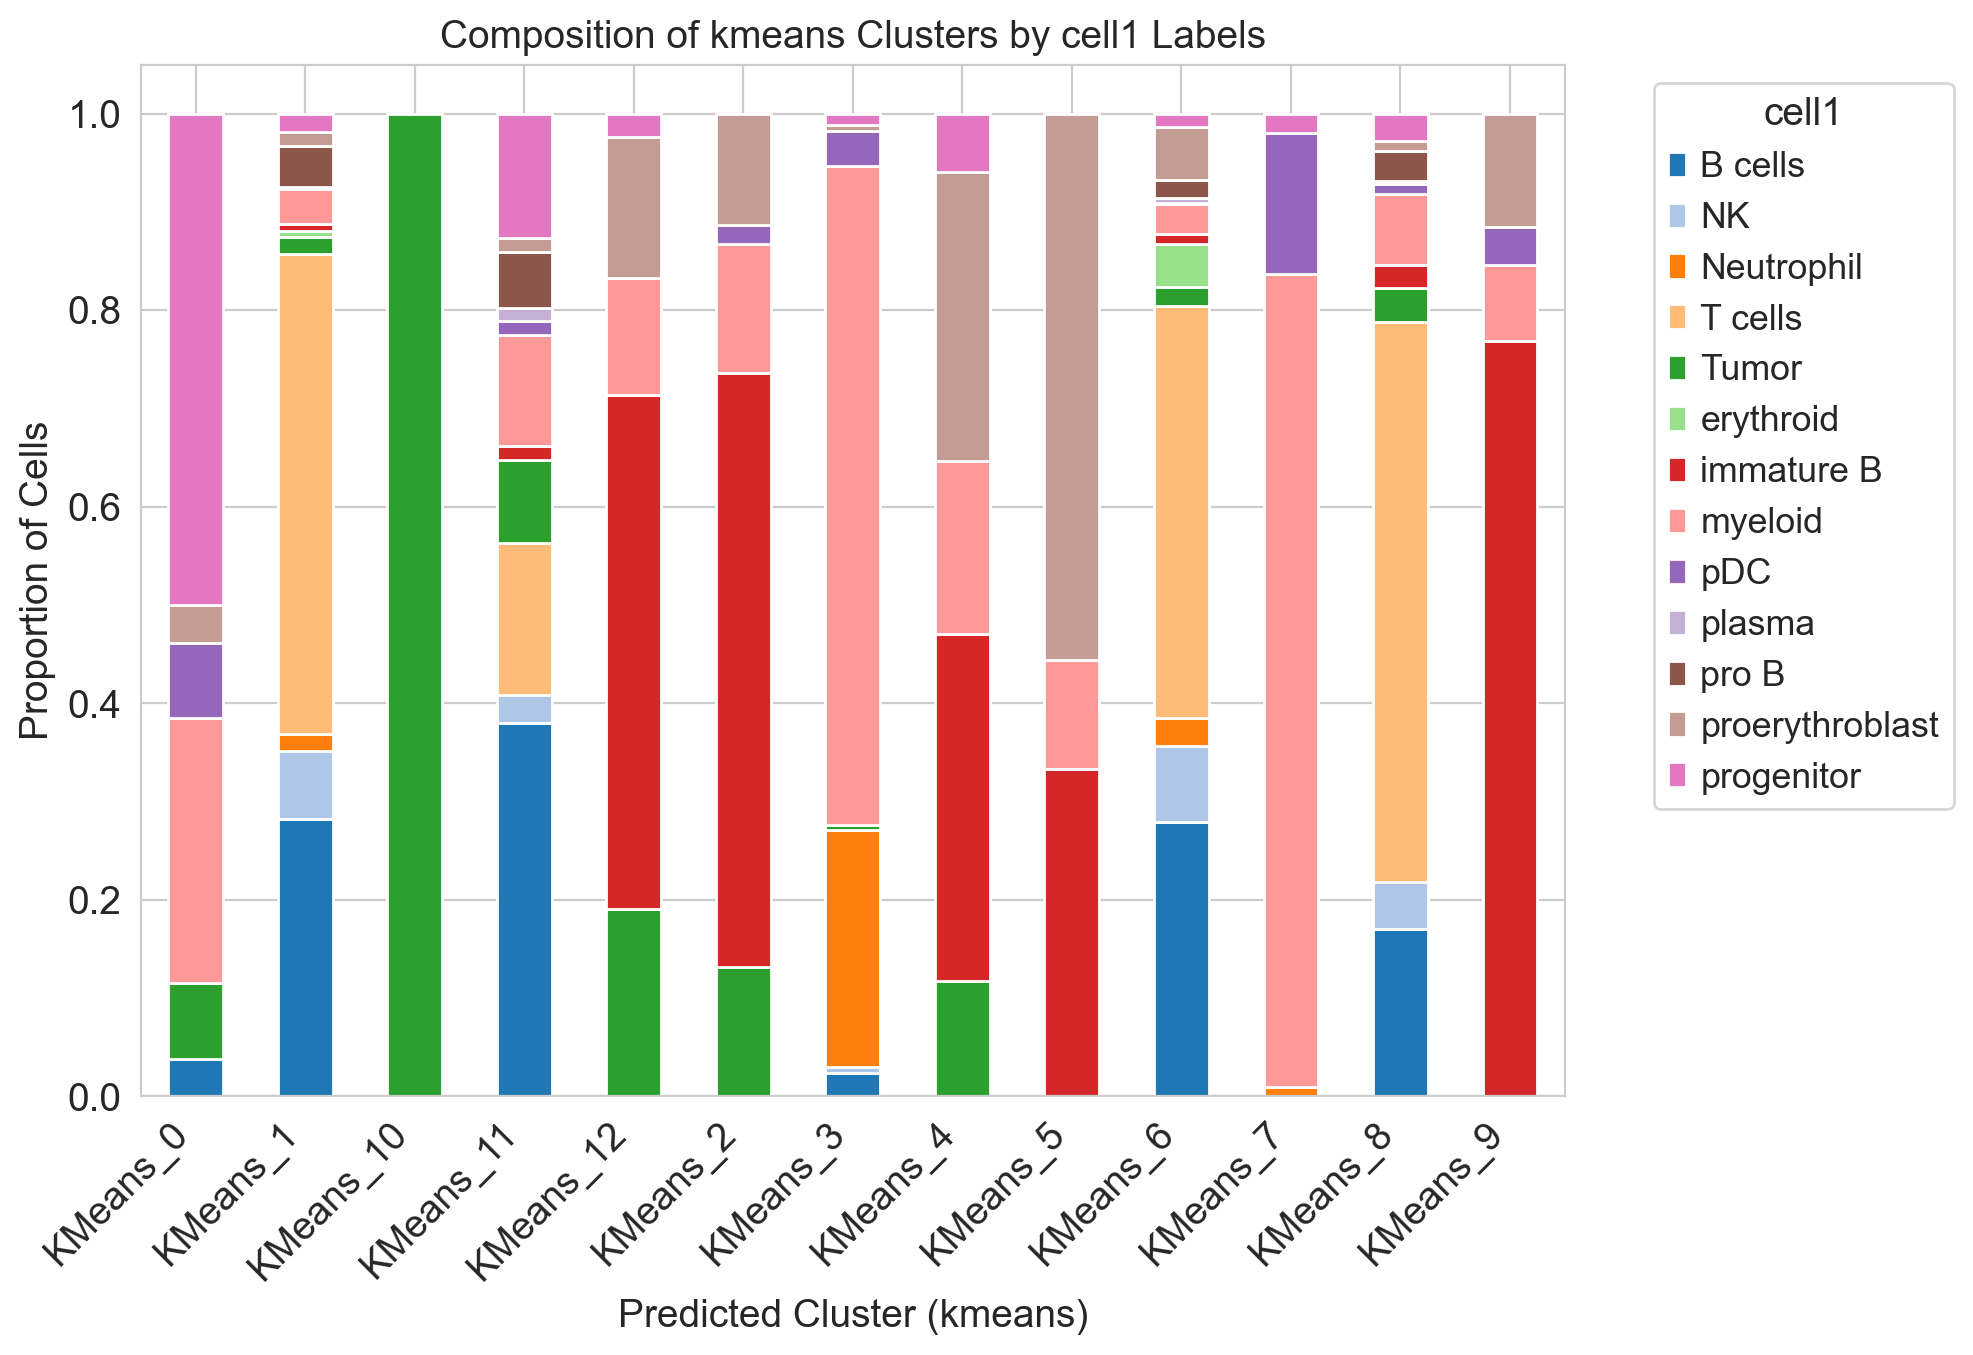


Generating Composition Plot for: louvain


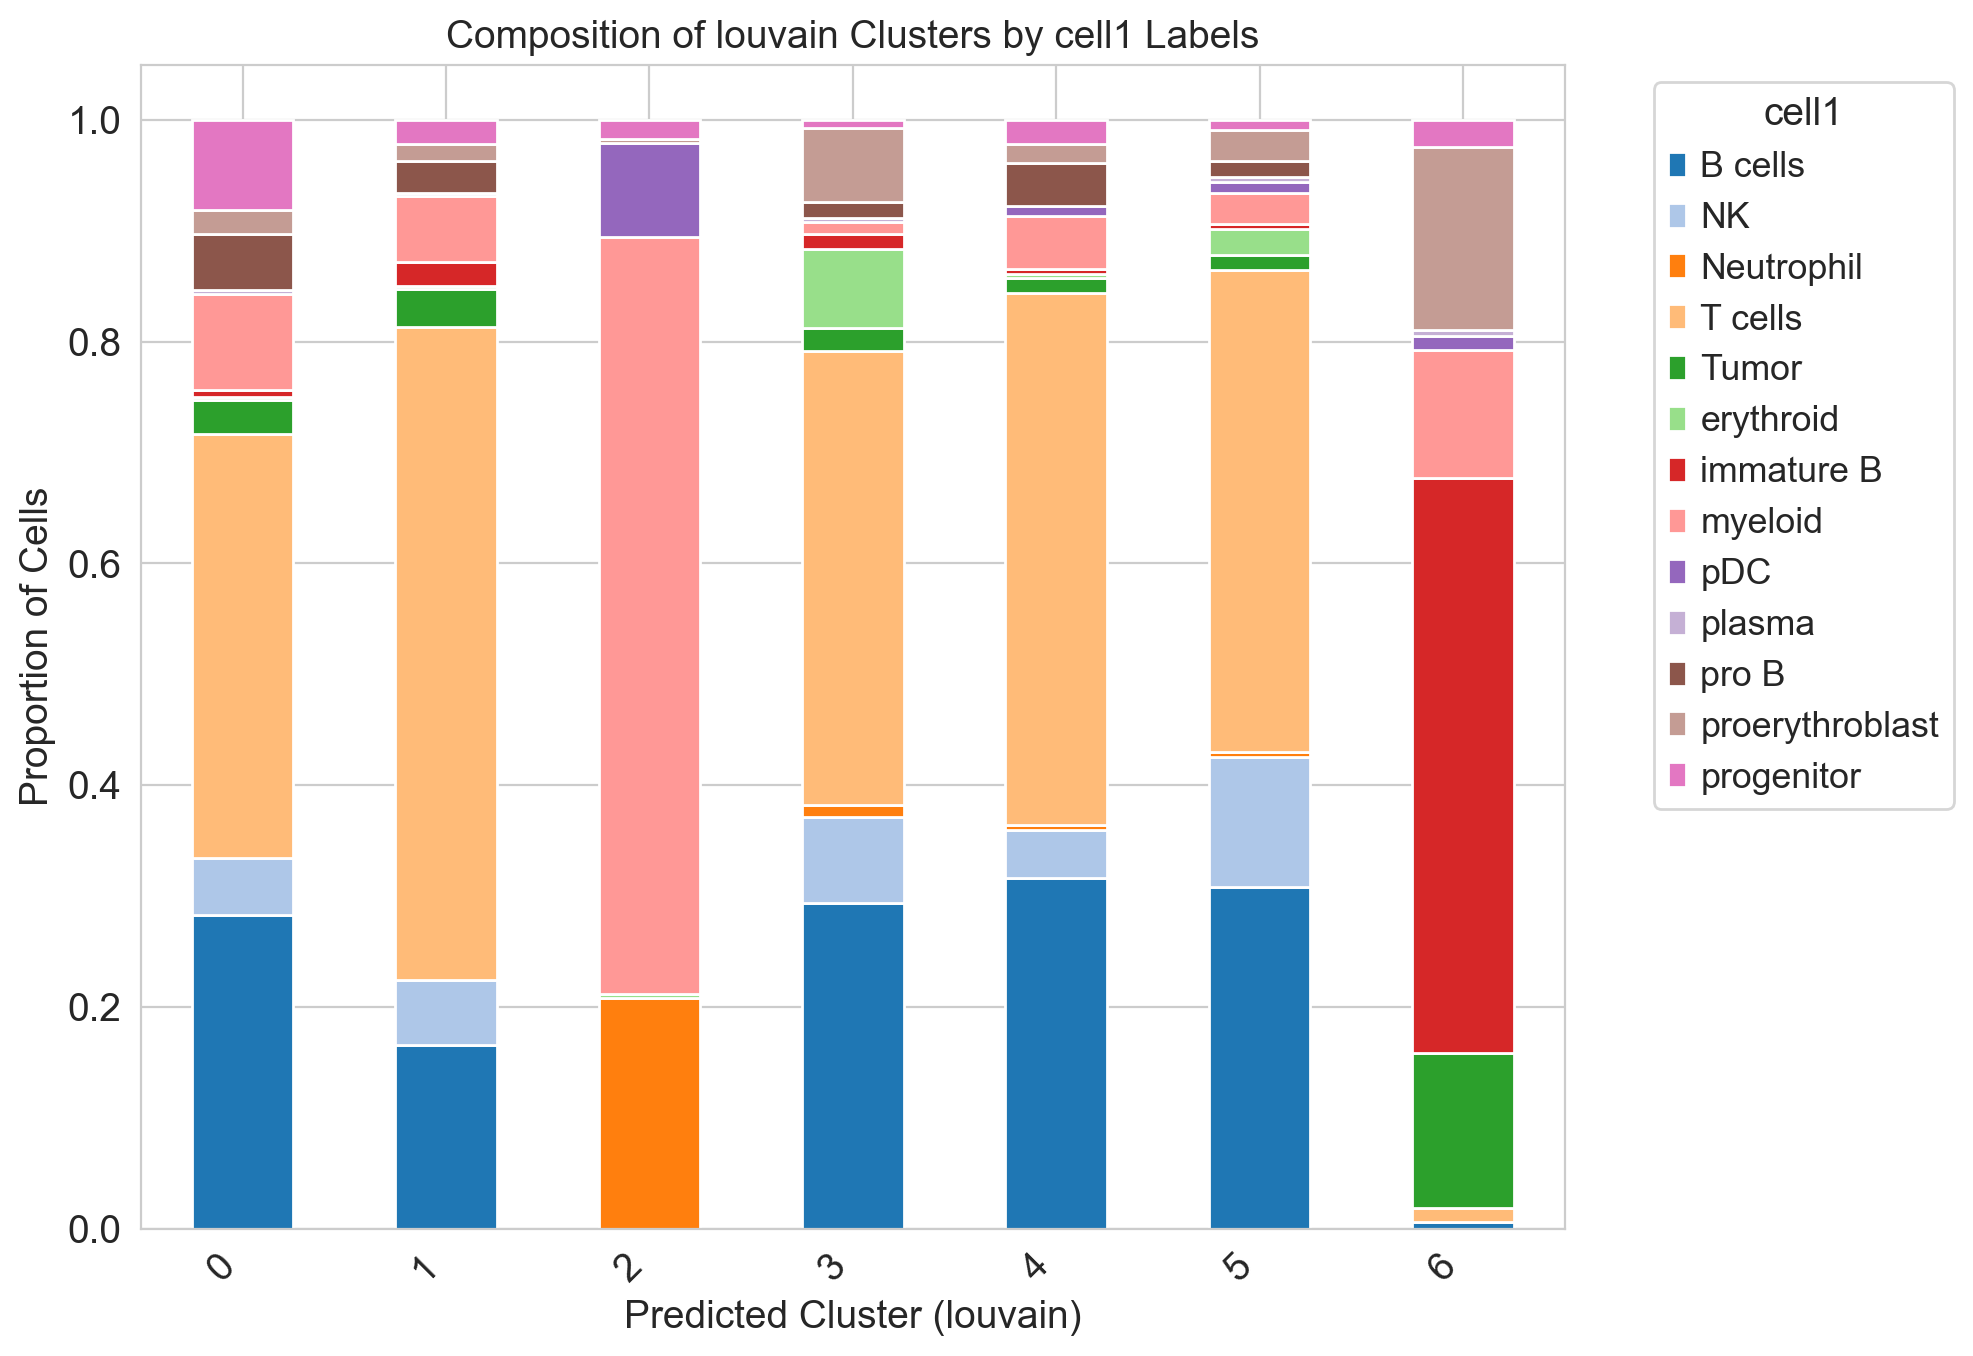


Generating Composition Plot for: leiden


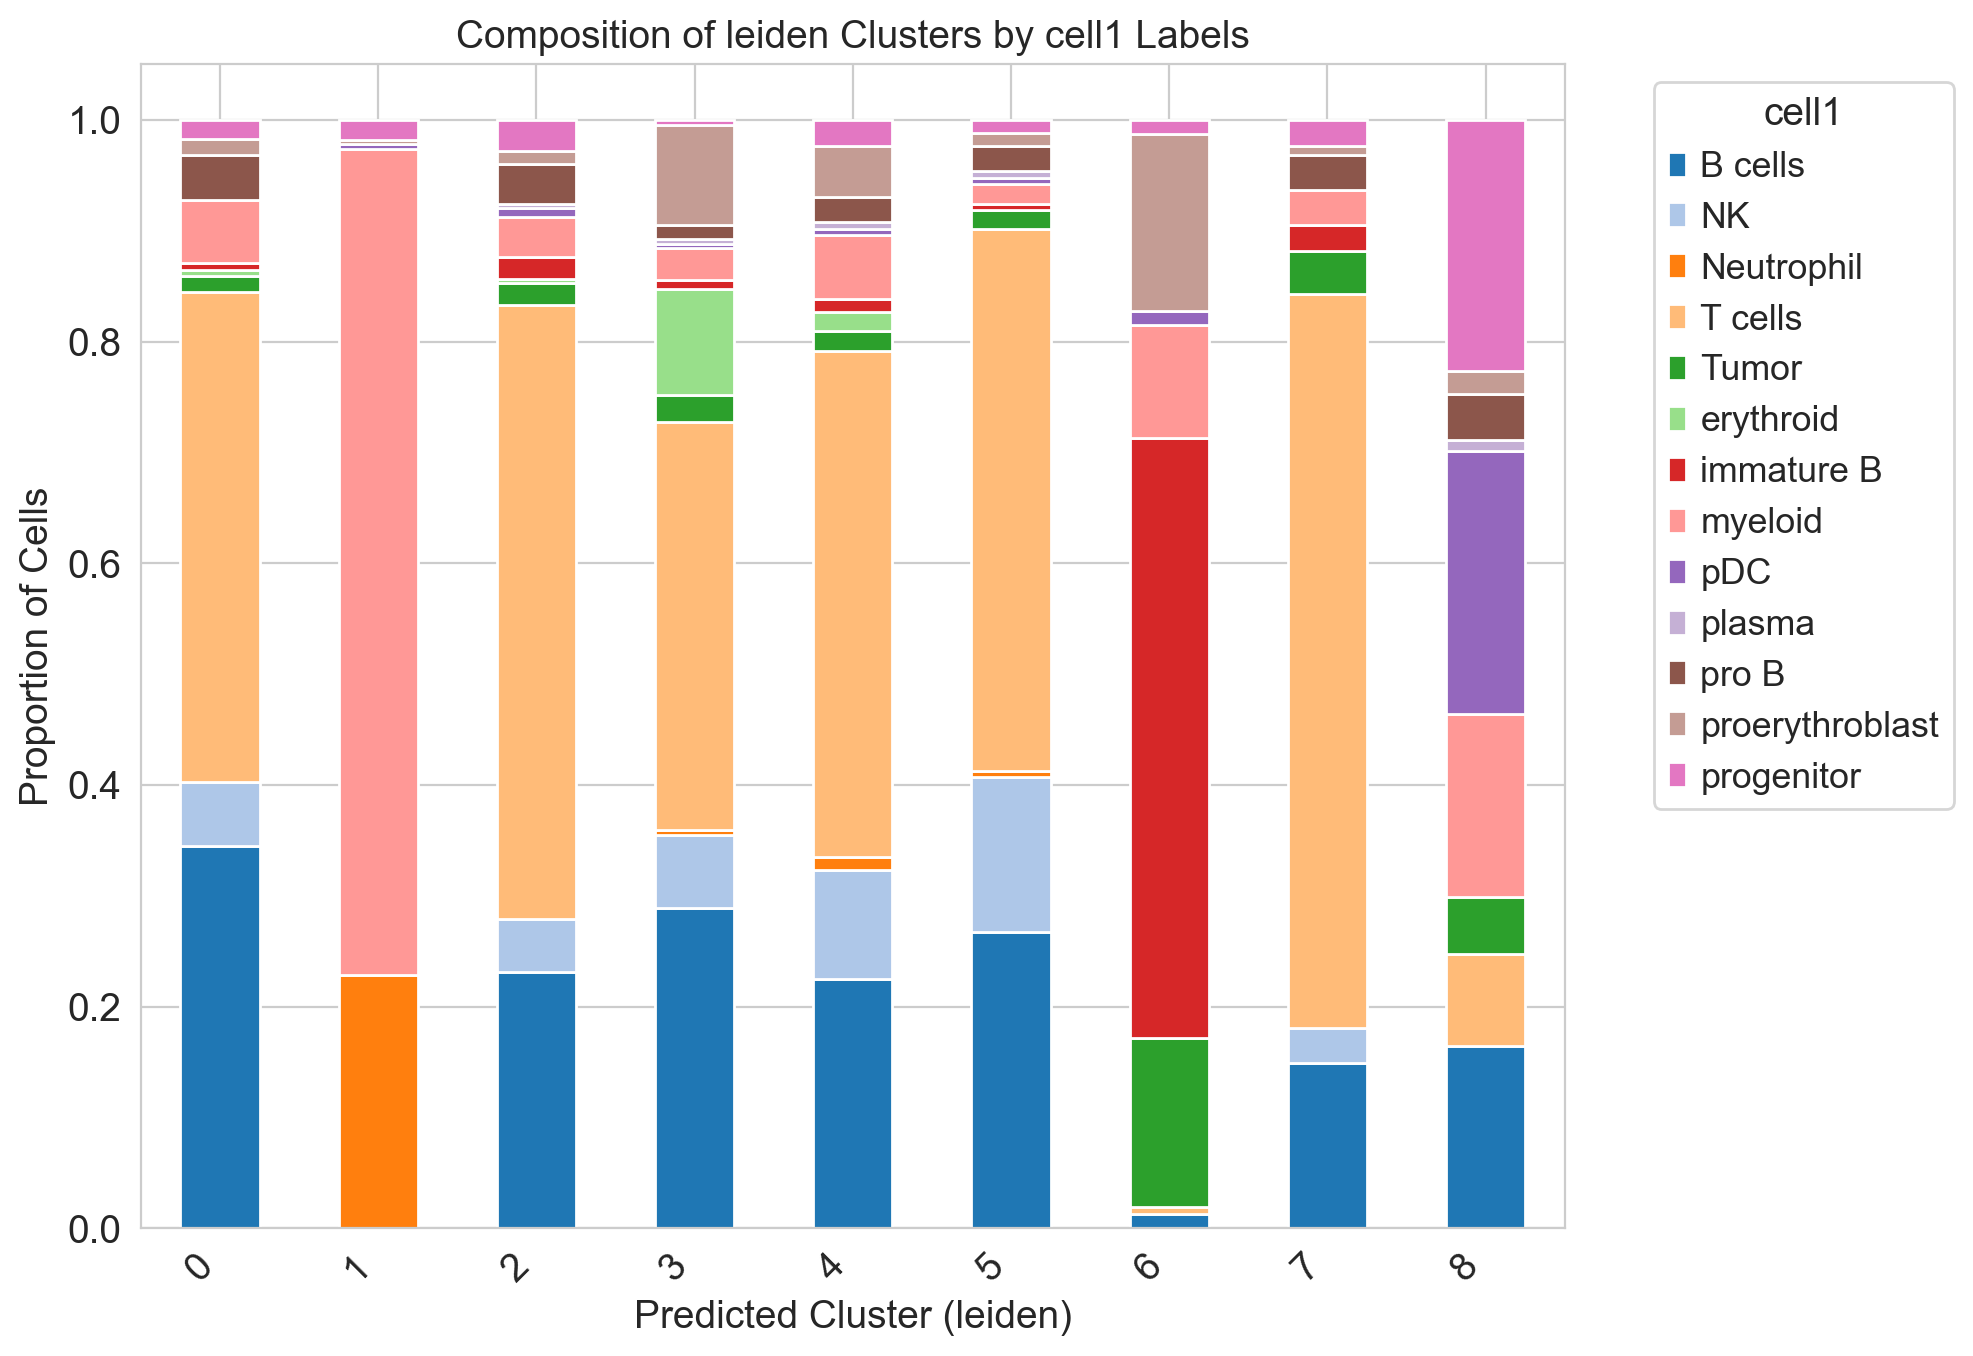


--- 4. GMM Entropy Distribution per 'cell1' Label ---


/var/folders/m2/lbk735w547j5jf8nwvk8vnj40000gn/T/ipykernel_59979/454821130.py:149: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median_entropy = entropy_df.groupby(ground_truth_key)['GMM_entropy'].median().sort_values()
/var/folders/m2/lbk735w547j5jf8nwvk8vnj40000gn/T/ipykernel_59979/454821130.py:153: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=entropy_df, y=ground_truth_key, x='GMM_entropy', order=ordered_labels, palette='viridis')


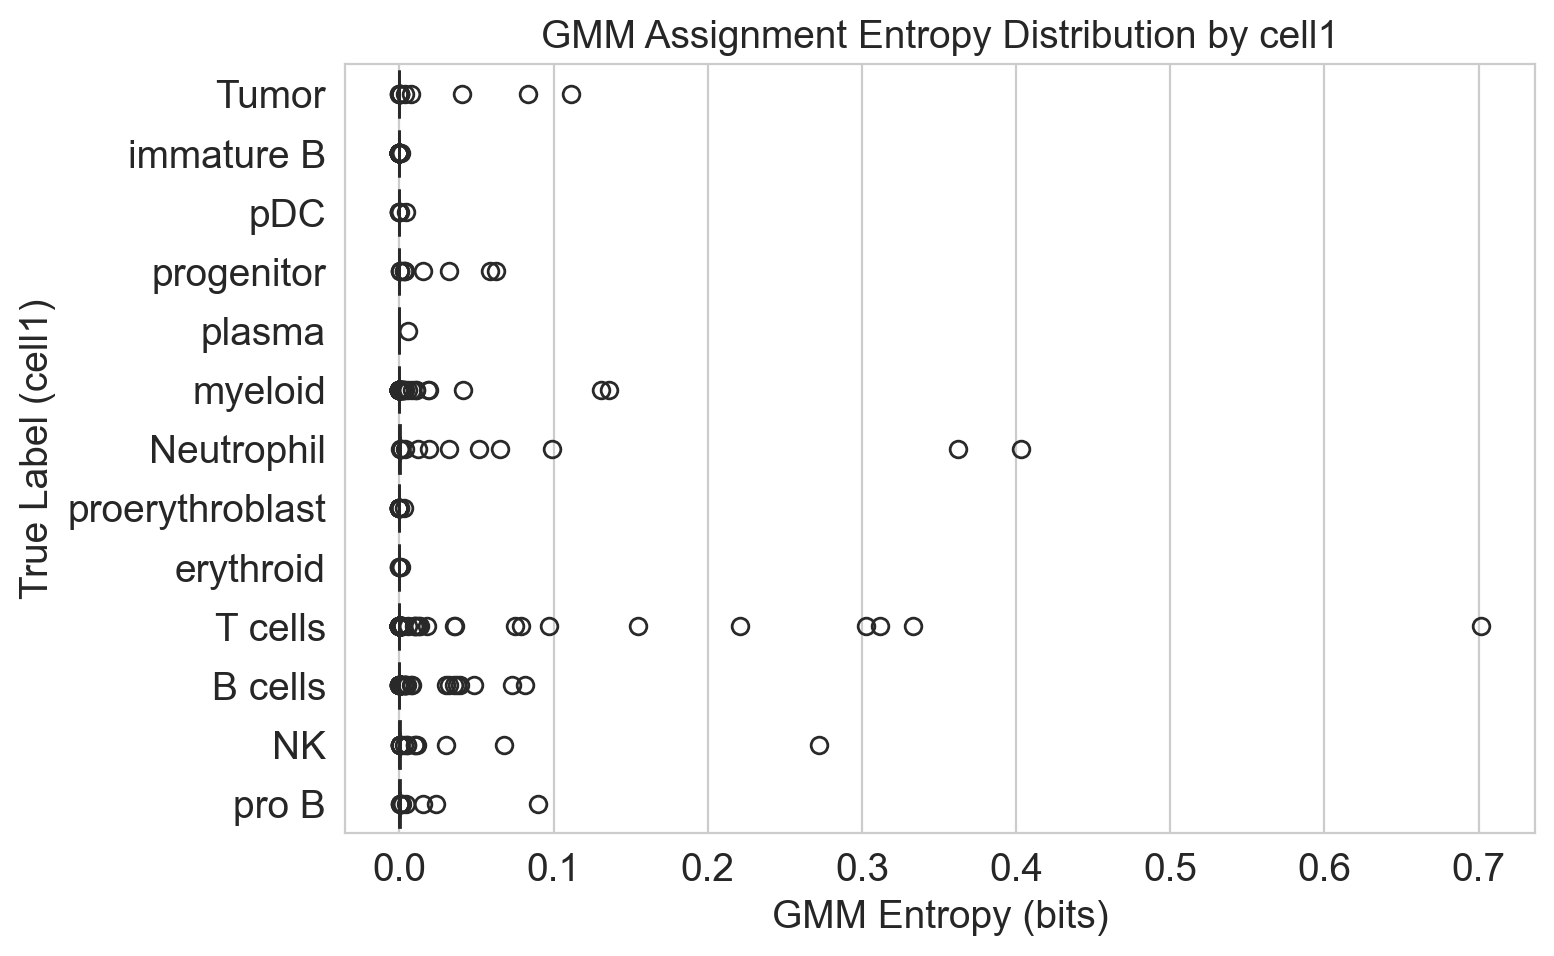


Interpretation Guide:
- Higher entropy for a cell indicates it has similar probabilities of belonging to multiple GMM clusters (more uncertainty/ambiguity).
- Lower entropy indicates the cell is strongly assigned to one GMM cluster.
- Examining entropy distribution within known 'cell1' groups can reveal:
  - Groups with consistently low entropy: Likely well-separated and confidently clustered by GMM.
  - Groups with consistently high entropy: May represent intermediate states, poorly separated populations, or areas where GMM struggles.
  - Groups with wide entropy variance: Might contain subpopulations with different clustering certainties.

--- Evaluation Complete ---



In [8]:
# --- Evaluation Against Known Cell-Identity Labels ---
print("\n" + "="*50)
print("--- Starting Evaluation Against Known Cell Labels ---")
print("="*50 + "\n")

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import (
    adjusted_rand_score,
    normalized_mutual_info_score,
    homogeneity_score,
    completeness_score,
    v_measure_score,
    confusion_matrix
)
# --- Configuration ---
# Choose the ground truth label column from embed_adata.obs
# 'cell1' (coarser) or 'cell2' (finer) are good candidates based on the data exploration cell
ground_truth_key = 'cell1'

# Choose the clustering results columns from embed_adata.obs to evaluate
# The notebook previously added: 'GMM_cluster', 'kmeans', 'louvain', 'leiden'
clustering_keys = ['GMM_cluster', 'kmeans', 'louvain', 'leiden']

# --- Check if keys exist ---
if ground_truth_key not in embed_adata.obs.columns:
    raise KeyError(f"Ground truth key '{ground_truth_key}' not found in embed_adata.obs. Available keys: {list(embed_adata.obs.columns)}")

valid_clustering_keys = []
for key in clustering_keys:
    if key in embed_adata.obs.columns:
        valid_clustering_keys.append(key)
    else:
        print(f"Warning: Clustering key '{key}' not found in embed_adata.obs. Skipping evaluation for this key.")
clustering_keys = valid_clustering_keys

if not clustering_keys:
    print("No valid clustering keys found to evaluate. Exiting evaluation section.")
else:

    true_labels = embed_adata.obs[ground_truth_key]

    # --- 1. Calculate and Print Metrics ---
    print(f"\n--- 1. Clustering Evaluation Metrics (vs '{ground_truth_key}') ---")
    metrics_results = {}
    for key in clustering_keys:
        print(f"\nEvaluating: {key}")
        predicted_labels = embed_adata.obs[key]

        ari = adjusted_rand_score(true_labels, predicted_labels)
        nmi = normalized_mutual_info_score(true_labels, predicted_labels)
        homogeneity = homogeneity_score(true_labels, predicted_labels)
        completeness = completeness_score(true_labels, predicted_labels)
        v_measure = v_measure_score(true_labels, predicted_labels)

        metrics_results[key] = {
            'ARI': ari,
            'NMI': nmi,
            'Homogeneity': homogeneity,
            'Completeness': completeness,
            'V-Measure': v_measure
        }
        print(f"  Adjusted Rand Index (ARI): {ari:.4f}")
        print(f"  Normalized Mutual Info (NMI): {nmi:.4f}")
        print(f"  Homogeneity: {homogeneity:.4f}")
        print(f"  Completeness: {completeness:.4f}")
        print(f"  V-Measure: {v_measure:.4f}")

    # Optional: Display metrics as a DataFrame
    metrics_df = pd.DataFrame(metrics_results).T
    print("\n--- Metrics Summary ---")
    print(metrics_df)
    print("-" * 25)


    # --- 2. Generate Confusion Matrices ---
    print(f"\n--- 2. Confusion Matrices (True Labels vs Predicted Clusters) ---")
    # Ensure true labels are categorical for proper ordering if they aren't already
    if not pd.api.types.is_categorical_dtype(true_labels):
        true_labels = true_labels.astype('category')
    true_label_names = true_labels.cat.categories

    for key in clustering_keys:
        print(f"\nGenerating Confusion Matrix for: {key}")
        predicted_labels = embed_adata.obs[key]
        # Ensure predicted labels are categorical for proper ordering
        # OLD: if not pd.api.types.is_categorical_dtype(predicted_labels):
        if not isinstance(predicted_labels.dtype, pd.CategoricalDtype): # CORRECTED LINE 88
             predicted_labels = predicted_labels.astype('category')
        predicted_label_names = predicted_labels.cat.categories

        cm = confusion_matrix(true_labels, predicted_labels, labels=true_label_names, normalize=None) # Use normalize='true' for row-wise proportions
        cm_df = cm_df = pd.crosstab(true_labels, predicted_labels)

        # Plotting the heatmap
        plt.figure(figsize=(max(8, len(predicted_label_names)*0.5), # Adjust width based on num clusters
                           max(6, len(true_label_names)*0.3))) # Adjust height based on num true labels
        sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues", linewidths=.5) # fmt=".2f" if normalized
        plt.title(f'Confusion Matrix: {key} vs {ground_truth_key}')
        plt.ylabel(f'True Labels ({ground_truth_key})')
        plt.xlabel(f'Predicted Clusters ({key})')
        plt.xticks(rotation=90)
        plt.yticks(rotation=0)
        plt.tight_layout()
        # plt.savefig(f'confusion_matrix_{key}_vs_{ground_truth_key}.png', dpi=150) # Optional save
        plt.show()


    # --- 3. Generate Stacked Bar Plots for Cluster Composition ---
    print(f"\n--- 3. Cluster Composition Bar Plots ---")
    # Using a qualitative colormap suitable for many categories
    try:
        # Try tab20 which has 20 distinct colors, fallback if fewer categories
        colors = plt.get_cmap('tab20').colors
    except ValueError:
        colors = plt.get_cmap('viridis').colors # Fallback

    for key in clustering_keys:
        print(f"\nGenerating Composition Plot for: {key}")
        # Create a cross-tabulation: counts of each true label within each predicted cluster
        ct = pd.crosstab(embed_adata.obs[key], embed_adata.obs[ground_truth_key])

        # Normalize by cluster (column sum = 1) to show percentage composition
        ct_norm = ct.apply(lambda x: x / x.sum(), axis=1)

        # Plotting
        ax = ct_norm.plot(kind='bar', stacked=True, figsize=(12, 7),
                          color=colors[:len(true_label_names)]) # Use subset of colors
        plt.title(f'Composition of {key} Clusters by {ground_truth_key} Labels')
        plt.xlabel(f'Predicted Cluster ({key})')
        plt.ylabel('Proportion of Cells')
        plt.xticks(rotation=45, ha='right')
        # Place legend outside the plot
        plt.legend(title=ground_truth_key, bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust rect to make space for legend
        # plt.savefig(f'composition_plot_{key}.png', dpi=150, bbox_inches='tight') # Optional save
        plt.show()


    # --- 4. Examine GMM Entropy Distribution per Known Label ---
    if 'GMM_entropy' in embed_adata.obs.columns and 'GMM_cluster' in clustering_keys:
        print(f"\n--- 4. GMM Entropy Distribution per '{ground_truth_key}' Label ---")

        # Create a DataFrame for easier plotting with seaborn
        entropy_df = embed_adata.obs[[ground_truth_key, 'GMM_entropy']].copy()

        # Calculate median entropy for sorting categories (optional but helpful)
        median_entropy = entropy_df.groupby(ground_truth_key)['GMM_entropy'].median().sort_values()
        ordered_labels = median_entropy.index

        plt.figure(figsize=(8, max(5, len(ordered_labels) * 0.3))) # Adjust height based on number of labels
        sns.boxplot(data=entropy_df, y=ground_truth_key, x='GMM_entropy', order=ordered_labels, palette='viridis')
        plt.title(f'GMM Assignment Entropy Distribution by {ground_truth_key}')
        plt.xlabel('GMM Entropy (bits)')
        plt.ylabel(f'True Label ({ground_truth_key})')
        plt.tight_layout()
        # plt.savefig(f'gmm_entropy_by_{ground_truth_key}.png', dpi=150, bbox_inches='tight') # Optional save
        plt.show()

        print("\nInterpretation Guide:")
        print(f"- Higher entropy for a cell indicates it has similar probabilities of belonging to multiple GMM clusters (more uncertainty/ambiguity).")
        print(f"- Lower entropy indicates the cell is strongly assigned to one GMM cluster.")
        print(f"- Examining entropy distribution within known '{ground_truth_key}' groups can reveal:")
        print(f"  - Groups with consistently low entropy: Likely well-separated and confidently clustered by GMM.")
        print(f"  - Groups with consistently high entropy: May represent intermediate states, poorly separated populations, or areas where GMM struggles.")
        print(f"  - Groups with wide entropy variance: Might contain subpopulations with different clustering certainties.")
    elif 'GMM_entropy' not in embed_adata.obs.columns:
         print(f"\n--- Skipping GMM Entropy analysis: 'GMM_entropy' not found in embed_adata.obs ---")
    else: # GMM_entropy exists but GMM_cluster wasn't evaluated
         print(f"\n--- Skipping GMM Entropy analysis: 'GMM_cluster' was not included in evaluated clustering_keys ---")


print("\n" + "="*50)
print("--- Evaluation Complete ---")
print("="*50 + "\n")